In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision.transforms import transforms


from lib.custmized_layer import convLayer, poolLayer, denseLayer
from lib.datasets.spikedataset import SpikeDataset, transform_cifar

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# some handy function to use
from lib.utils import save_model, load_dict, test_method, get_labels

# Test for raw and tailored CNN
Following tasks are done:
1. train and test for MNIST datast with raw_cnn and talor_cnn.
2. the same work for FashionMnist, and with the same set-up for network structure, since the input has the same size, and problems are similar. Besides, we want to show the difference of performance between the 3 networks, raw, tailored and snn with weights from tailored cnn. A network with smaller size can hugely  accelerate this pipeline.

In [3]:
# set up hyper params
BATCH_SIZE  = 32

# for full size dataset
EPOCH = 30
# for small size dataset, consistent with the Slayer
EPOCH2 = 100

NUM_WORKERS = 1

use_cuda = torch.cuda.is_available()

torch.manual_seed(1024)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
def plot_stats(stats):
    plt.figure(1)
    plt.semilogy(stats.training.lossLog, label='Training')
    plt.semilogy(stats.testing.lossLog, label='Testing')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(2)
    plt.plot(stats.training.accuracyLog, label='Training')
    plt.plot(stats.testing.accuracyLog, label='Testing')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Training
def train(model, model_name, trainloader, testloader, criterion, optimizer, stats, epoch):
    
    for epoch in tqdm(range(epoch)):
        # Reset training stats.
        stats.training.reset()
        tSt = datetime.now()
        model.train()    
        # Training loop.
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            # Gather training loss stats.
            stats.training.lossSum += loss.cpu().data.item()

            # Gather the training stats.
            _, predicted = torch.max(outputs.data, 1)

            stats.training.correctSamples += torch.sum(predicted == labels).data.item()
            stats.training.numSamples += len(labels)

            # Display training stats.
            # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
        # Update training stats.
        stats.training.update()
        # Reset testing stats.
        stats.testing.reset()
        model.eval()    
        # Testing loop.
        # Same steps as Training loops except loss backpropagation and weight update.
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)

            stats.testing.correctSamples += torch.sum(predicted == labels).data.item()
            stats.testing.numSamples += len(labels)

            loss = criterion(outputs, labels)
            stats.testing.lossSum += loss.cpu().data.item()


        # Update stats.
        stats.testing.update()
        if epoch%2==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())
    print('Finished Training')
    
    #test_acc(testloader, model)
    plot_stats(stats)
    save_model(model_name, model)

# Training for CNNs
* define the two CNNs
* define the train function
* train them and check the results

In [5]:
class Raw_CNN_Mnist(nn.Module):
    def __init__(self):
        super(Raw_CNN_Mnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 5, padding=1, bias=True)
        self.conv2 = nn.Conv2d(3, 12, 5, padding=1, bias=True)
        self.m1 = nn.MaxPool2d(2)
        self.m2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(12 * 5 * 5, 10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = self.m1(x) 
        x = F.relu(self.conv2(x)) 
        x = self.m2(x) 
        x = x.view(-1, 12 * 5 * 5)    
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

class Tailored_CNN_Mnist(nn.Module):
    def __init__(self):
        super(Tailored_CNN_Mnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 5, padding=1, bias=False)
        self.conv2 = nn.Conv2d(3, 12, 5, padding=1, bias=False)
        self.a1 = nn.AvgPool2d(2)
        self.a2 = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(12 * 5 * 5, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.a1(x)
        x = F.relu(self.conv2(x))
        x = self.a2(x)
        x = x.view(-1, 12 * 5 * 5)   
        x = self.fc1(x) 
        return F.log_softmax(x, dim=1)
    
# the learningStat class    
class learningStat():
    '''
    This class collect the learning statistics over the epoch.

    Usage:

    This class is designed to be used with learningStats instance although it can be used separately.

    >>> trainingStat = learningStat()
    '''
    def __init__(self):
        self.lossSum = 0
        self.correctSamples = 0
        self.numSamples = 0
        self.minloss = None
        self.maxAccuracy = None
        self.lossLog = []
        self.accuracyLog = []
        self.bestLoss = False
        self.bestAccuracy = False

    def reset(self):
        '''
        Reset the learning staistics. 
        This should usually be done before the start of an epoch so that new statistics counts can be accumulated.

        Usage:

        >>> trainingStat.reset()
        '''
        self.lossSum = 0
        self.correctSamples = 0
        self.numSamples = 0

    def loss(self):
        '''
        Returns the average loss calculated from the point the stats was reset.

        Usage:

        >>> loss = trainingStat.loss()
        '''
        if self.numSamples > 0: 
            return self.lossSum/self.numSamples 
        else:   
            return None

    def accuracy(self):
        '''
        Returns the average accuracy calculated from the point the stats was reset.

        Usage:

        >>> accuracy = trainingStat.accuracy()
        '''
        if self.numSamples > 0 and self.correctSamples > 0:
            return self.correctSamples/self.numSamples  
        else:   
            return None

    def update(self):
        '''
        Updates the stats of the current session and resets the measures for next session.

        Usage:

        >>> trainingStat.update()
        '''
        currentLoss = self.loss()
        self.lossLog.append(currentLoss)
        if self.minloss is None:
            self.minloss = currentLoss
        else:
            if currentLoss < self.minloss:
                self.minloss = currentLoss
                self.bestLoss = True
            else:
                self.bestLoss = False
            # self.minloss = self.minloss if self.minloss < currentLoss else currentLoss

        currentAccuracy = self.accuracy()
        self.accuracyLog.append(currentAccuracy)
        if self.maxAccuracy is None:
            self.maxAccuracy = currentAccuracy
        else:
            if currentAccuracy > self.maxAccuracy:
                self.maxAccuracy = currentAccuracy
                self.bestAccuracy = True
            else:
                self.bestAccuracy = False
            # self.maxAccuracy = self.maxAccuracy if self.maxAccuracy > currentAccuracy else currentAccuracy

    def displayString(self):
        loss = self.loss()
        accuracy = self.accuracy()
        minloss = self.minloss
        maxAccuracy = self.maxAccuracy

        if loss is None:    # no stats available
            return None
        elif accuracy is None: 
            if minloss is None: # accuracy and minloss stats is not available
                return 'loss = %-12.5g'%(loss)
            else:   # accuracy is not available but minloss is available
                return 'loss = %-12.5g (min = %-12.5g)'%(loss, minloss)
        else:
            if minloss is None and maxAccuracy is None: # minloss and maxAccuracy is available
                return 'loss = %-12.5g        %-12s   \taccuracy = %-10.5g        %-10s '%(loss, ' ', accuracy, ' ')
            else:   # all stats are available
                return 'loss = %-12.5g (min = %-12.5g)  \taccuracy = %-10.5g (max = %-10.5g)'%(loss, minloss, accuracy, maxAccuracy)

class learningStats():
    '''
    This class provides mechanism to collect learning stats for training and testing, and displaying them efficiently.

    Usage:

    .. code-block:: python
    
        stats = learningStats()

        for epoch in range(100):
            tSt = datetime.now()

            stats.training.reset()
            for i in trainingLoop:
                # other main stuffs
                stats.training.correctSamples += numberOfCorrectClassification
                stats.training.numSamples     += numberOfSamplesProcessed
                stats.training.lossSum        += currentLoss
                stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
            stats.training.update()

            stats.testing.reset()
            for i in testingLoop
                # other main stuffs
                stats.testing.correctSamples += numberOfCorrectClassification
                stats.testing.numSamples     += numberOfSamplesProcessed
                stats.testing.lossSum        += currentLoss
                stats.print(epoch, i)
            stats.training.update()

    '''
    def __init__(self):
        self.linesPrinted = 0
        self.training = learningStat()
        self.testing  = learningStat()

    def update(self):
        '''
        Updates the stats for training and testing and resets the measures for next session.

        Usage:

        >>> stats.update()
        '''
        self.training.update()
        self.training.reset()
        self.testing.update()
        self.testing.reset()

    def print(self, epoch, iter=None, timeElapsed=None):
        '''
        Prints the available learning statistics from the current session on the console.
        For Linux systems, prints the data on same terminal space (might not work properly on other systems).

        Arguments:
            * ``epoch``: epoch counter to display (required).
            * ``iter``: iteration counter to display (not required).
            * ``timeElapsed``: runtime information (not required).

        Usage:

        .. code-block:: python

            # prints stats with epoch index provided
            stats.print(epoch) 

            # prints stats with epoch index and iteration index provided
            stats.print(epoch, iter=i) 
            
            # prints stats with epoch index, iteration index and time elapsed information provided
            stats.print(epoch, iter=i, timeElapsed=time) 
        '''
        print('\033[%dA'%(self.linesPrinted))
        
        self.linesPrinted = 1

        epochStr   = 'Epoch : %10d'%(epoch)
        iterStr    = '' if iter is None else '(i = %7d)'%(iter)
        profileStr = '' if timeElapsed is None else ', %12.4f ms elapsed'%(timeElapsed * 1000)

        print(epochStr + iterStr + profileStr)
        print(self.training.displayString())
        self.linesPrinted += 2
        if self.testing.displayString() is not None:
            print(self.testing.displayString())
            self.linesPrinted += 1

    def plot(self, figures=(1, 2), saveFig=False, path=''):
        '''
        Plots the available learning statistics.

        Arguments:
            * ``figures``: Index of figure ID to plot on. Default is figure(1) for loss plot and figure(2) for accuracy plot.
            * ``saveFig``(``bool``): flag to save figure into a file.
            * ``path``: path to save the file. Defaule is ``''``.

        Usage:

        .. code-block:: python

            # plot stats
            stats.plot() 

            # plot stats figures specified
            stats.print(figures=(10, 11)) 
        '''
        plt.figure(figures[0])
        plt.cla()
        if len(self.training.lossLog) > 0:
            plt.semilogy(self.training.lossLog, label='Training')
        if len(self.testing.lossLog) > 0:
            plt.semilogy(self.testing .lossLog, label='Testing')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        if saveFig is True: 
            plt.savefig(path + 'loss.png')
            # plt.close()

        plt.figure(figures[1])
        plt.cla()
        if len(self.training.accuracyLog) > 0:
            plt.plot(self.training.accuracyLog, label='Training')
        if len(self.testing.accuracyLog) > 0:
            plt.plot(self.testing .accuracyLog, label='Testing')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend() 
        if saveFig is True: 
            plt.savefig(path + 'accuracy.png')
            # plt.close()

    def save(self, filename=''):
        '''
        Saves the learning satatistics logs.

        Arguments:
            * ``filename``: filename to save the logs. ``accuracy.txt`` and ``loss.txt`` will be appended

        Usage:

        .. code-block:: python

            # save stats
            stats.save() 

            # save stats filename specified
            stats.save(filename='Run101-0.001-') # Run101-0.001-accuracy.txt and Run101-0.001-loss.txt
        '''

        with open(filename + 'loss.txt', 'wt') as loss:
            loss.write('#%11s %11s\r\n'%('Train', 'Test'))
            for i in range(len(self.training.lossLog)): 
                loss.write('%12.6g %12.6g \r\n'%(self.training.lossLog[i], self.testing.lossLog[i]))

        with open(filename + 'accuracy.txt', 'wt') as accuracy:
            accuracy.write('#%11s %11s\r\n'%('Train', 'Test'))
            if self.training.accuracyLog != [None]*len(self.training.accuracyLog):
                for i in range(len(self.training.accuracyLog)): 
                    accuracy.write('%12.6g %12.6g \r\n'%(self.training.accuracyLog[i], self.testing.accuracyLog[i]))

## experiment MNIST
* We used two versions of dataset sizes for the experiments, since the Slayer model takes long time to train, and we train it on small dataset size (500 samples). We trained the raw CNN and tailored CNN on small size dataset to keep the consistency with the slayer, and train them on full size dataset to check how raw CNN, tailored CNN and the SNN with transfered weights perform differently.

In [6]:
class MNIST500(Dataset):
    def __init__(self, datasetPath, train=False):
        self.path = datasetPath
        ds = MNIST(datasetPath, train=train, download=True, transform=transforms.Compose([
            transforms.ToTensor()]))
        self.samples = [ds[i] for i in range(0, 500)]

    def __getitem__(self, index):
        x, y = self.samples[index]
        return x, y

    def __len__(self):
        return len(self.samples)
    
class FashionMNIST500(Dataset):
    def __init__(self, datasetPath, train=False):
        self.path = datasetPath
        ds = FashionMNIST(datasetPath, train=train, download=True, transform=transforms.Compose([
            transforms.ToTensor()]))
        self.samples = [ds[i] for i in range(0, 500)]

    def __getitem__(self, index):
        x, y = self.samples[index]
        return x, y

    def __len__(self):
        return len(self.samples)

### for full size MNIST

In [7]:
trainset_cnn = MNIST(root='./data', train=True, transform=transforms.Compose([
            transforms.ToTensor()]))

trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset_cnn = MNIST(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor()]))

testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

60000


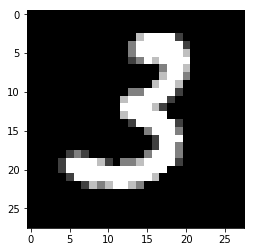

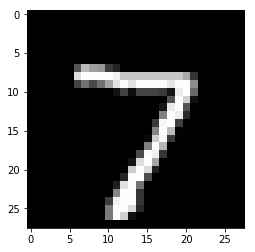

In [8]:
# check if we choose the correct dataset
print(len(trainset_cnn))
plt.imshow(next(iter(trainloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

plt.imshow(next(iter(testloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

* train the raw CNN on MNIST

  3%|▎         | 1/30 [00:12<05:49, 12.04s/it]


Epoch :          0,   12035.6100 ms elapsed
loss = 0.0088273    (min = 0.0088273   )  	accuracy = 0.91478    (max = 0.91478   )
loss = 0.0026293    (min = 0.0026293   )  	accuracy = 0.9753     (max = 0.9753    )


 10%|█         | 3/30 [00:37<05:33, 12.36s/it]


Epoch :          2,   12839.7760 ms elapsed
loss = 0.002099     (min = 0.002099    )  	accuracy = 0.97958    (max = 0.97958   )
loss = 0.0015369    (min = 0.0015369   )  	accuracy = 0.9839     (max = 0.9839    )


 17%|█▋        | 5/30 [01:02<05:10, 12.43s/it]


Epoch :          4,   12181.3970 ms elapsed
loss = 0.0015742    (min = 0.0015742   )  	accuracy = 0.9844     (max = 0.9844    )
loss = 0.0013805    (min = 0.0013805   )  	accuracy = 0.9868     (max = 0.9868    )


 23%|██▎       | 7/30 [01:27<04:45, 12.43s/it]


Epoch :          6,   12250.6260 ms elapsed
loss = 0.0012952    (min = 0.0012952   )  	accuracy = 0.98673    (max = 0.98673   )
loss = 0.0016885    (min = 0.0012826   )  	accuracy = 0.9823     (max = 0.9869    )


 30%|███       | 9/30 [01:51<04:19, 12.35s/it]


Epoch :          8,   12177.0990 ms elapsed
loss = 0.0011093    (min = 0.0011093   )  	accuracy = 0.98862    (max = 0.98862   )
loss = 0.0014096    (min = 0.0012826   )  	accuracy = 0.9854     (max = 0.9869    )


 37%|███▋      | 11/30 [02:16<03:52, 12.24s/it]


Epoch :         10,   12370.5490 ms elapsed
loss = 0.0009686    (min = 0.0009686   )  	accuracy = 0.99047    (max = 0.99047   )
loss = 0.0012847    (min = 0.0012826   )  	accuracy = 0.9877     (max = 0.9878    )


 43%|████▎     | 13/30 [02:41<03:31, 12.46s/it]


Epoch :         12,   12805.2560 ms elapsed
loss = 0.0008788    (min = 0.0008788   )  	accuracy = 0.99117    (max = 0.99117   )
loss = 0.0013783    (min = 0.0012017   )  	accuracy = 0.9864     (max = 0.988     )


 50%|█████     | 15/30 [03:06<03:05, 12.37s/it]


Epoch :         14,   12118.5320 ms elapsed
loss = 0.00077356   (min = 0.00077356  )  	accuracy = 0.99193    (max = 0.99193   )
loss = 0.0012041    (min = 0.0012017   )  	accuracy = 0.9883     (max = 0.989     )


 57%|█████▋    | 17/30 [03:29<02:38, 12.17s/it]


Epoch :         16,   11940.4080 ms elapsed
loss = 0.00072891   (min = 0.00072891  )  	accuracy = 0.99228    (max = 0.99228   )
loss = 0.0013091    (min = 0.0012017   )  	accuracy = 0.989      (max = 0.989     )


 63%|██████▎   | 19/30 [03:55<02:15, 12.36s/it]


Epoch :         18,   12460.3740 ms elapsed
loss = 0.00061216   (min = 0.00061216  )  	accuracy = 0.99367    (max = 0.99367   )
loss = 0.0015893    (min = 0.0012017   )  	accuracy = 0.9865     (max = 0.989     )


 70%|███████   | 21/30 [04:19<01:50, 12.32s/it]


Epoch :         20,   12285.4910 ms elapsed
loss = 0.0005901    (min = 0.0005901   )  	accuracy = 0.99373    (max = 0.99373   )
loss = 0.0012665    (min = 0.0012017   )  	accuracy = 0.9887     (max = 0.989     )


 77%|███████▋  | 23/30 [04:44<01:26, 12.39s/it]


Epoch :         22,   12110.1340 ms elapsed
loss = 0.00054975   (min = 0.00054975  )  	accuracy = 0.99393    (max = 0.99407   )
loss = 0.0015998    (min = 0.0012017   )  	accuracy = 0.9873     (max = 0.989     )


 83%|████████▎ | 25/30 [05:09<01:02, 12.42s/it]


Epoch :         24,   12209.8740 ms elapsed
loss = 0.00048562   (min = 0.00048562  )  	accuracy = 0.99482    (max = 0.99487   )
loss = 0.001663     (min = 0.0012017   )  	accuracy = 0.9857     (max = 0.989     )


 90%|█████████ | 27/30 [05:33<00:36, 12.25s/it]


Epoch :         26,   11998.0280 ms elapsed
loss = 0.00048399   (min = 0.00048399  )  	accuracy = 0.9945     (max = 0.99487   )
loss = 0.001468     (min = 0.0012017   )  	accuracy = 0.9873     (max = 0.989     )


 97%|█████████▋| 29/30 [05:59<00:12, 12.47s/it]


Epoch :         28,   12741.1530 ms elapsed
loss = 0.00042797   (min = 0.00042797  )  	accuracy = 0.9957     (max = 0.9957    )
loss = 0.0016742    (min = 0.0012017   )  	accuracy = 0.9872     (max = 0.989     )


100%|██████████| 30/30 [06:10<00:00, 12.25s/it]


Finished Training


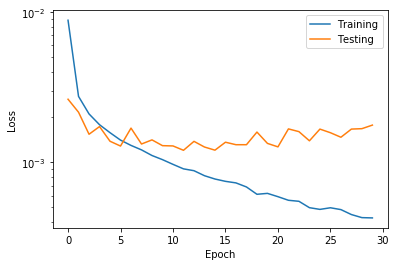

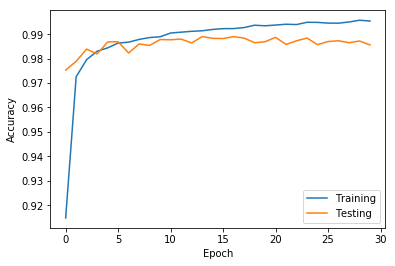

Saving models...
The classification accuracy:  0.9856



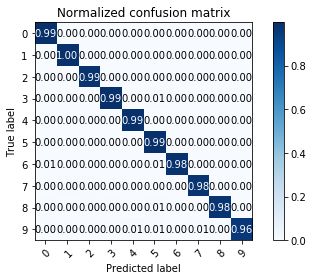

In [9]:
raw_cnn_mnist = Raw_CNN_Mnist().to(device)

raw_criterion = nn.CrossEntropyLoss()
raw_optimizer = optim.Adam(raw_cnn_mnist.parameters(), lr=0.001)
raw_stats = learningStats()

train(raw_cnn_mnist,'raw_cnn_mnist',
      trainloader_cnn,testloader_cnn,
      raw_criterion, 
      raw_optimizer,
      raw_stats,
      epoch=EPOCH)

y_true, y_pred = get_labels(raw_cnn_mnist, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* train the trailored CNN on MNIST

  3%|▎         | 1/30 [00:12<06:08, 12.71s/it]


Epoch :          0,   12711.7930 ms elapsed
loss = 0.010878     (min = 0.010878    )  	accuracy = 0.89515    (max = 0.89515   )
loss = 0.0043183    (min = 0.0043183   )  	accuracy = 0.958      (max = 0.958     )


 10%|█         | 3/30 [00:36<05:34, 12.40s/it]


Epoch :          2,   11881.4220 ms elapsed
loss = 0.0028035    (min = 0.0028035   )  	accuracy = 0.97237    (max = 0.97237   )
loss = 0.0021418    (min = 0.0021418   )  	accuracy = 0.9781     (max = 0.9781    )


 17%|█▋        | 5/30 [01:01<05:06, 12.25s/it]


Epoch :          4,   12143.3920 ms elapsed
loss = 0.0019923    (min = 0.0019923   )  	accuracy = 0.98095    (max = 0.98095   )
loss = 0.00178      (min = 0.00178     )  	accuracy = 0.9819     (max = 0.9819    )


 23%|██▎       | 7/30 [01:26<04:46, 12.47s/it]


Epoch :          6,   12528.9660 ms elapsed
loss = 0.001599     (min = 0.001599    )  	accuracy = 0.98407    (max = 0.98407   )
loss = 0.0014042    (min = 0.0014042   )  	accuracy = 0.9864     (max = 0.9864    )


 30%|███       | 9/30 [01:51<04:24, 12.57s/it]


Epoch :          8,   12826.9770 ms elapsed
loss = 0.0013755    (min = 0.0013755   )  	accuracy = 0.98668    (max = 0.98668   )
loss = 0.0013106    (min = 0.0013106   )  	accuracy = 0.9869     (max = 0.9869    )


 37%|███▋      | 11/30 [02:17<03:59, 12.60s/it]


Epoch :         10,   12229.8570 ms elapsed
loss = 0.0011973    (min = 0.0011973   )  	accuracy = 0.98813    (max = 0.98813   )
loss = 0.0016213    (min = 0.0013106   )  	accuracy = 0.984      (max = 0.9869    )


 43%|████▎     | 13/30 [02:43<03:38, 12.87s/it]


Epoch :         12,   13399.7860 ms elapsed
loss = 0.001078     (min = 0.001078    )  	accuracy = 0.98943    (max = 0.98943   )
loss = 0.0014717    (min = 0.0012791   )  	accuracy = 0.9851     (max = 0.9874    )


 50%|█████     | 15/30 [03:08<03:12, 12.82s/it]


Epoch :         14,   12806.1160 ms elapsed
loss = 0.0010071    (min = 0.0010071   )  	accuracy = 0.98975    (max = 0.98975   )
loss = 0.0012806    (min = 0.0012354   )  	accuracy = 0.9865     (max = 0.9874    )


 57%|█████▋    | 17/30 [03:34<02:45, 12.70s/it]


Epoch :         16,   12688.0670 ms elapsed
loss = 0.00093503   (min = 0.00093503  )  	accuracy = 0.99062    (max = 0.99062   )
loss = 0.0013335    (min = 0.0012354   )  	accuracy = 0.986      (max = 0.9874    )


 63%|██████▎   | 19/30 [04:01<02:23, 13.05s/it]


Epoch :         18,   12965.3830 ms elapsed
loss = 0.0008673    (min = 0.0008673   )  	accuracy = 0.99158    (max = 0.99158   )
loss = 0.001227     (min = 0.001227    )  	accuracy = 0.9881     (max = 0.9881    )


 70%|███████   | 21/30 [04:25<01:54, 12.67s/it]


Epoch :         20,   12439.9660 ms elapsed
loss = 0.00081363   (min = 0.00081363  )  	accuracy = 0.99168    (max = 0.99168   )
loss = 0.0012357    (min = 0.001227    )  	accuracy = 0.988      (max = 0.9881    )


 77%|███████▋  | 23/30 [04:50<01:27, 12.51s/it]


Epoch :         22,   12454.0510 ms elapsed
loss = 0.00075703   (min = 0.00075703  )  	accuracy = 0.99188    (max = 0.99217   )
loss = 0.001541     (min = 0.001227    )  	accuracy = 0.9848     (max = 0.9881    )


 83%|████████▎ | 25/30 [05:15<01:03, 12.71s/it]


Epoch :         24,   13053.7760 ms elapsed
loss = 0.00073053   (min = 0.00073053  )  	accuracy = 0.99247    (max = 0.99247   )
loss = 0.0014415    (min = 0.001227    )  	accuracy = 0.9863     (max = 0.9881    )


 90%|█████████ | 27/30 [05:41<00:38, 12.72s/it]


Epoch :         26,   12606.8670 ms elapsed
loss = 0.00068124   (min = 0.00068124  )  	accuracy = 0.9926     (max = 0.99285   )
loss = 0.0013533    (min = 0.001227    )  	accuracy = 0.9869     (max = 0.9881    )


 97%|█████████▋| 29/30 [06:06<00:12, 12.71s/it]


Epoch :         28,   12785.7030 ms elapsed
loss = 0.00063123   (min = 0.00063123  )  	accuracy = 0.99343    (max = 0.99343   )
loss = 0.0014281    (min = 0.001227    )  	accuracy = 0.9864     (max = 0.9881    )


100%|██████████| 30/30 [06:18<00:00, 12.50s/it]


Finished Training


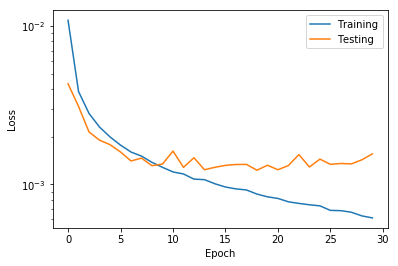

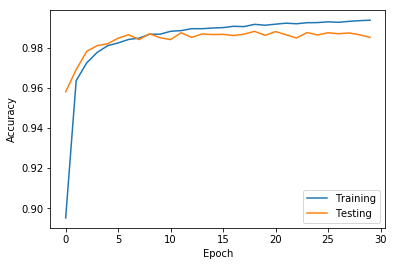

Saving models...
The classification accuracy:  0.9851



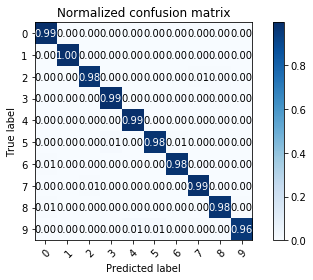

In [10]:
tailored_cnn_mnist = Tailored_CNN_Mnist().to(device)

t_criterion = nn.CrossEntropyLoss()
t_optimizer = optim.Adam(tailored_cnn_mnist.parameters(), lr=0.001)
t_stats = learningStats()

train(tailored_cnn_mnist,'tailor_cnn_mnist', 
      trainloader_cnn,testloader_cnn, 
      t_criterion, 
      t_optimizer,
      t_stats,
      epoch=EPOCH)

y_true, y_pred = get_labels(tailored_cnn_mnist, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

### for small size SMNIST

In [11]:
trainset_cnn = MNIST500('./data', train=True)

trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset_cnn = MNIST500('./data', train=False)

testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

* train the raw CNN on SMNIST

  1%|          | 1/100 [00:00<00:37,  2.64it/s]


Epoch :          0,     377.9150 ms elapsed
loss = 0.073066     (min = 0.073066    )  	accuracy = 0.194      (max = 0.194     )
loss = 0.072009     (min = 0.072009    )  	accuracy = 0.322      (max = 0.322     )


  3%|▎         | 3/100 [00:01<00:35,  2.73it/s]


Epoch :          2,     344.2660 ms elapsed
loss = 0.060105     (min = 0.060105    )  	accuracy = 0.636      (max = 0.636     )
loss = 0.055489     (min = 0.055489    )  	accuracy = 0.578      (max = 0.578     )


  5%|▌         | 5/100 [00:01<00:34,  2.76it/s]


Epoch :          4,     353.4050 ms elapsed
loss = 0.029311     (min = 0.029311    )  	accuracy = 0.798      (max = 0.798     )
loss = 0.032222     (min = 0.032222    )  	accuracy = 0.648      (max = 0.648     )


  7%|▋         | 7/100 [00:02<00:33,  2.79it/s]


Epoch :          6,     345.6660 ms elapsed
loss = 0.017417     (min = 0.017417    )  	accuracy = 0.864      (max = 0.864     )
loss = 0.022292     (min = 0.022292    )  	accuracy = 0.784      (max = 0.784     )


  9%|▉         | 9/100 [00:03<00:32,  2.78it/s]


Epoch :          8,     349.1940 ms elapsed
loss = 0.013371     (min = 0.013371    )  	accuracy = 0.884      (max = 0.884     )
loss = 0.018576     (min = 0.018576    )  	accuracy = 0.798      (max = 0.798     )


 11%|█         | 11/100 [00:03<00:31,  2.81it/s]


Epoch :         10,     349.4920 ms elapsed
loss = 0.010996     (min = 0.010996    )  	accuracy = 0.894      (max = 0.894     )
loss = 0.015315     (min = 0.015315    )  	accuracy = 0.824      (max = 0.824     )


 13%|█▎        | 13/100 [00:04<00:31,  2.76it/s]


Epoch :         12,     354.6020 ms elapsed
loss = 0.0097654    (min = 0.0097654   )  	accuracy = 0.914      (max = 0.914     )
loss = 0.015604     (min = 0.015315    )  	accuracy = 0.836      (max = 0.836     )


 15%|█▌        | 15/100 [00:05<00:30,  2.80it/s]


Epoch :         14,     358.0370 ms elapsed
loss = 0.0079541    (min = 0.0079541   )  	accuracy = 0.928      (max = 0.928     )
loss = 0.012687     (min = 0.012687    )  	accuracy = 0.854      (max = 0.854     )


 17%|█▋        | 17/100 [00:06<00:29,  2.83it/s]


Epoch :         16,     347.1030 ms elapsed
loss = 0.0075793    (min = 0.0073749   )  	accuracy = 0.93       (max = 0.938     )
loss = 0.011915     (min = 0.011915    )  	accuracy = 0.866      (max = 0.866     )


 19%|█▉        | 19/100 [00:06<00:28,  2.85it/s]


Epoch :         18,     343.2050 ms elapsed
loss = 0.0064406    (min = 0.0064406   )  	accuracy = 0.944      (max = 0.944     )
loss = 0.011104     (min = 0.011104    )  	accuracy = 0.88       (max = 0.88      )


 21%|██        | 21/100 [00:07<00:27,  2.85it/s]


Epoch :         20,     340.0960 ms elapsed
loss = 0.0055861    (min = 0.0055861   )  	accuracy = 0.954      (max = 0.954     )
loss = 0.010904     (min = 0.010904    )  	accuracy = 0.878      (max = 0.88      )


 23%|██▎       | 23/100 [00:08<00:27,  2.83it/s]


Epoch :         22,     349.1780 ms elapsed
loss = 0.0047991    (min = 0.0047991   )  	accuracy = 0.958      (max = 0.958     )
loss = 0.010717     (min = 0.010717    )  	accuracy = 0.872      (max = 0.88      )


 25%|██▌       | 25/100 [00:08<00:27,  2.72it/s]


Epoch :         24,     384.1580 ms elapsed
loss = 0.0039661    (min = 0.0039661   )  	accuracy = 0.964      (max = 0.964     )
loss = 0.0096849    (min = 0.0096849   )  	accuracy = 0.898      (max = 0.898     )


 27%|██▋       | 27/100 [00:09<00:26,  2.71it/s]


Epoch :         26,     375.8030 ms elapsed
loss = 0.0034569    (min = 0.0034569   )  	accuracy = 0.97       (max = 0.97      )
loss = 0.009958     (min = 0.0096849   )  	accuracy = 0.884      (max = 0.898     )


 29%|██▉       | 29/100 [00:10<00:26,  2.71it/s]


Epoch :         28,     370.5850 ms elapsed
loss = 0.0029147    (min = 0.0029147   )  	accuracy = 0.98       (max = 0.98      )
loss = 0.0099532    (min = 0.0096558   )  	accuracy = 0.882      (max = 0.898     )


 31%|███       | 31/100 [00:11<00:25,  2.71it/s]


Epoch :         30,     377.3150 ms elapsed
loss = 0.0025863    (min = 0.0025863   )  	accuracy = 0.978      (max = 0.984     )
loss = 0.0096847    (min = 0.0096558   )  	accuracy = 0.894      (max = 0.898     )


 33%|███▎      | 33/100 [00:11<00:25,  2.65it/s]


Epoch :         32,     374.4660 ms elapsed
loss = 0.0021265    (min = 0.0021265   )  	accuracy = 0.99       (max = 0.99      )
loss = 0.0096909    (min = 0.0090897   )  	accuracy = 0.89       (max = 0.898     )


 35%|███▌      | 35/100 [00:12<00:24,  2.67it/s]


Epoch :         34,     374.8320 ms elapsed
loss = 0.001731     (min = 0.001731    )  	accuracy = 0.996      (max = 0.996     )
loss = 0.0099535    (min = 0.0089595   )  	accuracy = 0.884      (max = 0.906     )


 37%|███▋      | 37/100 [00:13<00:23,  2.69it/s]


Epoch :         36,     367.3420 ms elapsed
loss = 0.0014674    (min = 0.0014674   )  	accuracy = 0.994      (max = 0.996     )
loss = 0.0090942    (min = 0.0089595   )  	accuracy = 0.904      (max = 0.906     )


 39%|███▉      | 39/100 [00:14<00:22,  2.66it/s]


Epoch :         38,     375.8850 ms elapsed
loss = 0.0011973    (min = 0.0011973   )  	accuracy = 0.996      (max = 0.996     )
loss = 0.0092016    (min = 0.0089595   )  	accuracy = 0.902      (max = 0.906     )


 41%|████      | 41/100 [00:14<00:21,  2.72it/s]


Epoch :         40,     358.0320 ms elapsed
loss = 0.0011456    (min = 0.0011456   )  	accuracy = 1          (max = 1         )
loss = 0.0092646    (min = 0.0089595   )  	accuracy = 0.902      (max = 0.906     )


 43%|████▎     | 43/100 [00:15<00:20,  2.76it/s]


Epoch :         42,     361.7160 ms elapsed
loss = 0.00085961   (min = 0.00085961  )  	accuracy = 1          (max = 1         )
loss = 0.0094805    (min = 0.0089595   )  	accuracy = 0.902      (max = 0.906     )


 45%|████▌     | 45/100 [00:16<00:20,  2.73it/s]


Epoch :         44,     361.5110 ms elapsed
loss = 0.00075743   (min = 0.00075743  )  	accuracy = 1          (max = 1         )
loss = 0.0093066    (min = 0.0089595   )  	accuracy = 0.906      (max = 0.906     )


 47%|████▋     | 47/100 [00:17<00:19,  2.73it/s]


Epoch :         46,     352.7300 ms elapsed
loss = 0.00069165   (min = 0.00069165  )  	accuracy = 1          (max = 1         )
loss = 0.0090933    (min = 0.0089595   )  	accuracy = 0.898      (max = 0.906     )


 49%|████▉     | 49/100 [00:17<00:18,  2.72it/s]


Epoch :         48,     348.3970 ms elapsed
loss = 0.00055353   (min = 0.00055353  )  	accuracy = 1          (max = 1         )
loss = 0.0091743    (min = 0.0089595   )  	accuracy = 0.91       (max = 0.91      )


 51%|█████     | 51/100 [00:18<00:17,  2.76it/s]


Epoch :         50,     362.7670 ms elapsed
loss = 0.00053454   (min = 0.00053454  )  	accuracy = 1          (max = 1         )
loss = 0.0091601    (min = 0.0089595   )  	accuracy = 0.904      (max = 0.91      )


 53%|█████▎    | 53/100 [00:19<00:17,  2.72it/s]


Epoch :         52,     360.3880 ms elapsed
loss = 0.00041295   (min = 0.00041295  )  	accuracy = 1          (max = 1         )
loss = 0.0094552    (min = 0.0089595   )  	accuracy = 0.902      (max = 0.91      )


 55%|█████▌    | 55/100 [00:20<00:16,  2.73it/s]


Epoch :         54,     361.6170 ms elapsed
loss = 0.00040373   (min = 0.00040373  )  	accuracy = 1          (max = 1         )
loss = 0.0093534    (min = 0.0089595   )  	accuracy = 0.91       (max = 0.912     )


 57%|█████▋    | 57/100 [00:20<00:15,  2.72it/s]


Epoch :         56,     373.6240 ms elapsed
loss = 0.00035884   (min = 0.00035884  )  	accuracy = 1          (max = 1         )
loss = 0.0097429    (min = 0.0089595   )  	accuracy = 0.898      (max = 0.912     )


 59%|█████▉    | 59/100 [00:21<00:15,  2.71it/s]


Epoch :         58,     366.9250 ms elapsed
loss = 0.00035539   (min = 0.00035539  )  	accuracy = 1          (max = 1         )
loss = 0.0097807    (min = 0.0089595   )  	accuracy = 0.906      (max = 0.912     )


 61%|██████    | 61/100 [00:22<00:14,  2.71it/s]


Epoch :         60,     376.1990 ms elapsed
loss = 0.00030085   (min = 0.00030085  )  	accuracy = 1          (max = 1         )
loss = 0.009319     (min = 0.0089595   )  	accuracy = 0.912      (max = 0.912     )


 63%|██████▎   | 63/100 [00:22<00:13,  2.70it/s]


Epoch :         62,     370.8100 ms elapsed
loss = 0.00025109   (min = 0.00025109  )  	accuracy = 1          (max = 1         )
loss = 0.0096871    (min = 0.0089595   )  	accuracy = 0.914      (max = 0.914     )


 65%|██████▌   | 65/100 [00:23<00:12,  2.77it/s]


Epoch :         64,     346.5350 ms elapsed
loss = 0.00022342   (min = 0.00022342  )  	accuracy = 1          (max = 1         )
loss = 0.0096827    (min = 0.0089595   )  	accuracy = 0.916      (max = 0.916     )


 67%|██████▋   | 67/100 [00:24<00:11,  2.80it/s]


Epoch :         66,     356.9960 ms elapsed
loss = 0.00021734   (min = 0.00021734  )  	accuracy = 1          (max = 1         )
loss = 0.0098369    (min = 0.0089595   )  	accuracy = 0.904      (max = 0.916     )


 69%|██████▉   | 69/100 [00:25<00:11,  2.68it/s]


Epoch :         68,     392.5900 ms elapsed
loss = 0.00018217   (min = 0.00018217  )  	accuracy = 1          (max = 1         )
loss = 0.0097312    (min = 0.0089595   )  	accuracy = 0.906      (max = 0.916     )


 71%|███████   | 71/100 [00:25<00:10,  2.66it/s]


Epoch :         70,     374.2530 ms elapsed
loss = 0.00018645   (min = 0.00018217  )  	accuracy = 1          (max = 1         )
loss = 0.0099672    (min = 0.0089595   )  	accuracy = 0.91       (max = 0.916     )


 73%|███████▎  | 73/100 [00:26<00:10,  2.66it/s]


Epoch :         72,     363.3750 ms elapsed
loss = 0.00015714   (min = 0.00015714  )  	accuracy = 1          (max = 1         )
loss = 0.0098851    (min = 0.0089595   )  	accuracy = 0.91       (max = 0.916     )


 75%|███████▌  | 75/100 [00:27<00:09,  2.62it/s]


Epoch :         74,     390.7290 ms elapsed
loss = 0.00015334   (min = 0.00015334  )  	accuracy = 1          (max = 1         )
loss = 0.010008     (min = 0.0089595   )  	accuracy = 0.912      (max = 0.916     )


 77%|███████▋  | 77/100 [00:28<00:08,  2.63it/s]


Epoch :         76,     369.3840 ms elapsed
loss = 0.00013723   (min = 0.00013723  )  	accuracy = 1          (max = 1         )
loss = 0.010057     (min = 0.0089595   )  	accuracy = 0.912      (max = 0.916     )


 79%|███████▉  | 79/100 [00:28<00:07,  2.70it/s]


Epoch :         78,     358.8760 ms elapsed
loss = 0.0001298    (min = 0.0001298   )  	accuracy = 1          (max = 1         )
loss = 0.010399     (min = 0.0089595   )  	accuracy = 0.904      (max = 0.916     )


 81%|████████  | 81/100 [00:29<00:07,  2.71it/s]


Epoch :         80,     355.3210 ms elapsed
loss = 0.00012162   (min = 0.00012162  )  	accuracy = 1          (max = 1         )
loss = 0.010156     (min = 0.0089595   )  	accuracy = 0.91       (max = 0.916     )


 83%|████████▎ | 83/100 [00:30<00:06,  2.71it/s]


Epoch :         82,     369.3030 ms elapsed
loss = 0.0001104    (min = 0.0001104   )  	accuracy = 1          (max = 1         )
loss = 0.010324     (min = 0.0089595   )  	accuracy = 0.906      (max = 0.916     )


 85%|████████▌ | 85/100 [00:31<00:05,  2.72it/s]


Epoch :         84,     370.5930 ms elapsed
loss = 0.00010705   (min = 0.00010705  )  	accuracy = 1          (max = 1         )
loss = 0.010291     (min = 0.0089595   )  	accuracy = 0.912      (max = 0.916     )


 87%|████████▋ | 87/100 [00:31<00:04,  2.75it/s]


Epoch :         86,     368.0210 ms elapsed
loss = 9.8249e-05   (min = 9.8249e-05  )  	accuracy = 1          (max = 1         )
loss = 0.010417     (min = 0.0089595   )  	accuracy = 0.906      (max = 0.916     )


 89%|████████▉ | 89/100 [00:32<00:04,  2.72it/s]


Epoch :         88,     365.2420 ms elapsed
loss = 9.2111e-05   (min = 9.2111e-05  )  	accuracy = 1          (max = 1         )
loss = 0.010469     (min = 0.0089595   )  	accuracy = 0.906      (max = 0.916     )


 91%|█████████ | 91/100 [00:33<00:03,  2.75it/s]


Epoch :         90,     360.6230 ms elapsed
loss = 8.8086e-05   (min = 8.8086e-05  )  	accuracy = 1          (max = 1         )
loss = 0.010538     (min = 0.0089595   )  	accuracy = 0.91       (max = 0.916     )


 93%|█████████▎| 93/100 [00:34<00:02,  2.79it/s]


Epoch :         92,     349.1530 ms elapsed
loss = 8.7367e-05   (min = 8.6141e-05  )  	accuracy = 1          (max = 1         )
loss = 0.010404     (min = 0.0089595   )  	accuracy = 0.908      (max = 0.916     )


 95%|█████████▌| 95/100 [00:34<00:01,  2.85it/s]


Epoch :         94,     333.5000 ms elapsed
loss = 7.8371e-05   (min = 7.8371e-05  )  	accuracy = 1          (max = 1         )
loss = 0.010631     (min = 0.0089595   )  	accuracy = 0.908      (max = 0.916     )


 97%|█████████▋| 97/100 [00:35<00:01,  2.88it/s]


Epoch :         96,     335.8990 ms elapsed
loss = 7.5269e-05   (min = 7.5269e-05  )  	accuracy = 1          (max = 1         )
loss = 0.01062      (min = 0.0089595   )  	accuracy = 0.908      (max = 0.916     )


 99%|█████████▉| 99/100 [00:36<00:00,  2.83it/s]


Epoch :         98,     351.7840 ms elapsed
loss = 7.3301e-05   (min = 7.3301e-05  )  	accuracy = 1          (max = 1         )
loss = 0.010706     (min = 0.0089595   )  	accuracy = 0.908      (max = 0.916     )


100%|██████████| 100/100 [00:36<00:00,  2.82it/s]


Finished Training


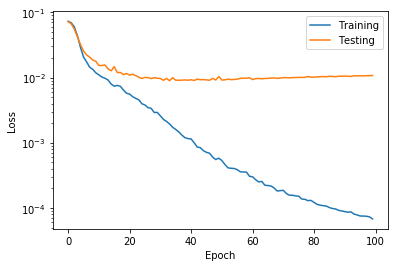

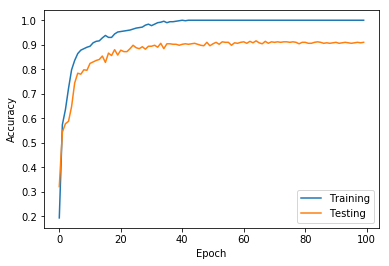

Saving models...
The classification accuracy:  0.91



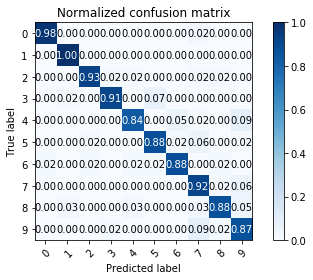

In [13]:
raw_cnn_mnist = Raw_CNN_Mnist().to(device)

raw_criterion = nn.CrossEntropyLoss()
raw_optimizer = optim.Adam(raw_cnn_mnist.parameters(), lr=0.001)
raw_stats = learningStats()

train(raw_cnn_mnist,'raw_cnn_Smnist',
      trainloader_cnn,testloader_cnn,
      raw_criterion, 
      raw_optimizer,
      raw_stats,
      epoch=EPOCH2)

y_true, y_pred = get_labels(raw_cnn_mnist, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* train the tailored CNN on SMNIST

  1%|          | 1/100 [00:00<00:35,  2.77it/s]


Epoch :          0,     360.7710 ms elapsed
loss = 0.073247     (min = 0.073247    )  	accuracy = 0.152      (max = 0.152     )
loss = 0.072515     (min = 0.072515    )  	accuracy = 0.302      (max = 0.302     )


  3%|▎         | 3/100 [00:01<00:34,  2.82it/s]


Epoch :          2,     343.4170 ms elapsed
loss = 0.06349      (min = 0.06349     )  	accuracy = 0.63       (max = 0.63      )
loss = 0.059522     (min = 0.059522    )  	accuracy = 0.646      (max = 0.646     )


  5%|▌         | 5/100 [00:01<00:33,  2.82it/s]


Epoch :          4,     356.6520 ms elapsed
loss = 0.032283     (min = 0.032283    )  	accuracy = 0.788      (max = 0.788     )
loss = 0.031008     (min = 0.031008    )  	accuracy = 0.698      (max = 0.698     )


  7%|▋         | 7/100 [00:02<00:32,  2.86it/s]


Epoch :          6,     352.4190 ms elapsed
loss = 0.018511     (min = 0.018511    )  	accuracy = 0.83       (max = 0.83      )
loss = 0.023527     (min = 0.023527    )  	accuracy = 0.736      (max = 0.736     )


  9%|▉         | 9/100 [00:03<00:31,  2.87it/s]


Epoch :          8,     337.8990 ms elapsed
loss = 0.014679     (min = 0.014679    )  	accuracy = 0.858      (max = 0.858     )
loss = 0.020998     (min = 0.020998    )  	accuracy = 0.772      (max = 0.772     )


 11%|█         | 11/100 [00:03<00:31,  2.86it/s]


Epoch :         10,     354.4700 ms elapsed
loss = 0.013048     (min = 0.013048    )  	accuracy = 0.882      (max = 0.882     )
loss = 0.018339     (min = 0.018339    )  	accuracy = 0.796      (max = 0.796     )


 13%|█▎        | 13/100 [00:04<00:30,  2.84it/s]


Epoch :         12,     355.0650 ms elapsed
loss = 0.012349     (min = 0.012349    )  	accuracy = 0.882      (max = 0.882     )
loss = 0.017902     (min = 0.017889    )  	accuracy = 0.8        (max = 0.806     )


 15%|█▌        | 15/100 [00:05<00:30,  2.81it/s]


Epoch :         14,     368.4190 ms elapsed
loss = 0.01109      (min = 0.01109     )  	accuracy = 0.886      (max = 0.886     )
loss = 0.016216     (min = 0.016216    )  	accuracy = 0.83       (max = 0.83      )


 17%|█▋        | 17/100 [00:05<00:29,  2.82it/s]


Epoch :         16,     360.6440 ms elapsed
loss = 0.0096187    (min = 0.0096187   )  	accuracy = 0.904      (max = 0.906     )
loss = 0.015148     (min = 0.015148    )  	accuracy = 0.84       (max = 0.84      )


 19%|█▉        | 19/100 [00:06<00:28,  2.84it/s]


Epoch :         18,     356.5600 ms elapsed
loss = 0.0092407    (min = 0.0092407   )  	accuracy = 0.906      (max = 0.906     )
loss = 0.015315     (min = 0.014858    )  	accuracy = 0.838      (max = 0.84      )


 21%|██        | 21/100 [00:07<00:27,  2.87it/s]


Epoch :         20,     337.5370 ms elapsed
loss = 0.0083473    (min = 0.0083473   )  	accuracy = 0.916      (max = 0.916     )
loss = 0.01402      (min = 0.01402     )  	accuracy = 0.85       (max = 0.85      )


 23%|██▎       | 23/100 [00:08<00:26,  2.88it/s]


Epoch :         22,     350.2990 ms elapsed
loss = 0.0074877    (min = 0.0074877   )  	accuracy = 0.924      (max = 0.932     )
loss = 0.013647     (min = 0.013647    )  	accuracy = 0.856      (max = 0.856     )


 25%|██▌       | 25/100 [00:08<00:26,  2.88it/s]


Epoch :         24,     346.9560 ms elapsed
loss = 0.0067578    (min = 0.0067578   )  	accuracy = 0.934      (max = 0.934     )
loss = 0.013403     (min = 0.013403    )  	accuracy = 0.868      (max = 0.868     )


 27%|██▋       | 27/100 [00:09<00:25,  2.83it/s]


Epoch :         26,     357.9370 ms elapsed
loss = 0.0061999    (min = 0.0061999   )  	accuracy = 0.942      (max = 0.942     )
loss = 0.013291     (min = 0.013291    )  	accuracy = 0.868      (max = 0.868     )


 29%|██▉       | 29/100 [00:10<00:24,  2.91it/s]


Epoch :         28,     332.8910 ms elapsed
loss = 0.0053298    (min = 0.0053298   )  	accuracy = 0.95       (max = 0.95      )
loss = 0.013254     (min = 0.013214    )  	accuracy = 0.86       (max = 0.868     )


 31%|███       | 31/100 [00:10<00:23,  2.88it/s]


Epoch :         30,     335.0120 ms elapsed
loss = 0.005104     (min = 0.005104    )  	accuracy = 0.95       (max = 0.95      )
loss = 0.012765     (min = 0.012765    )  	accuracy = 0.874      (max = 0.874     )


 33%|███▎      | 33/100 [00:11<00:23,  2.82it/s]


Epoch :         32,     371.4100 ms elapsed
loss = 0.0044031    (min = 0.0044031   )  	accuracy = 0.956      (max = 0.956     )
loss = 0.013101     (min = 0.012765    )  	accuracy = 0.87       (max = 0.876     )


 35%|███▌      | 35/100 [00:12<00:23,  2.81it/s]


Epoch :         34,     354.1540 ms elapsed
loss = 0.0041683    (min = 0.0041683   )  	accuracy = 0.958      (max = 0.958     )
loss = 0.013234     (min = 0.012765    )  	accuracy = 0.868      (max = 0.876     )


 37%|███▋      | 37/100 [00:12<00:22,  2.82it/s]


Epoch :         36,     340.0820 ms elapsed
loss = 0.003615     (min = 0.003615    )  	accuracy = 0.962      (max = 0.962     )
loss = 0.012903     (min = 0.012765    )  	accuracy = 0.876      (max = 0.876     )


 39%|███▉      | 39/100 [00:13<00:21,  2.84it/s]


Epoch :         38,     339.8950 ms elapsed
loss = 0.0032229    (min = 0.0032229   )  	accuracy = 0.97       (max = 0.978     )
loss = 0.013686     (min = 0.012765    )  	accuracy = 0.872      (max = 0.876     )


 41%|████      | 41/100 [00:14<00:20,  2.88it/s]


Epoch :         40,     340.9380 ms elapsed
loss = 0.0029016    (min = 0.0029016   )  	accuracy = 0.974      (max = 0.98      )
loss = 0.014044     (min = 0.012765    )  	accuracy = 0.87       (max = 0.876     )


 43%|████▎     | 43/100 [00:15<00:19,  2.94it/s]


Epoch :         42,     321.3870 ms elapsed
loss = 0.0026294    (min = 0.0026294   )  	accuracy = 0.984      (max = 0.984     )
loss = 0.013779     (min = 0.012765    )  	accuracy = 0.868      (max = 0.876     )


 45%|████▌     | 45/100 [00:15<00:18,  2.92it/s]


Epoch :         44,     342.6660 ms elapsed
loss = 0.0021489    (min = 0.0021489   )  	accuracy = 0.98       (max = 0.984     )
loss = 0.013425     (min = 0.012765    )  	accuracy = 0.876      (max = 0.876     )


 47%|████▋     | 47/100 [00:16<00:18,  2.87it/s]


Epoch :         46,     341.2620 ms elapsed
loss = 0.0019647    (min = 0.0019647   )  	accuracy = 0.992      (max = 0.992     )
loss = 0.014041     (min = 0.012765    )  	accuracy = 0.872      (max = 0.876     )


 49%|████▉     | 49/100 [00:17<00:17,  2.84it/s]


Epoch :         48,     351.2800 ms elapsed
loss = 0.0019103    (min = 0.0019103   )  	accuracy = 0.986      (max = 0.992     )
loss = 0.015002     (min = 0.012765    )  	accuracy = 0.868      (max = 0.876     )


 51%|█████     | 51/100 [00:17<00:17,  2.81it/s]


Epoch :         50,     363.3190 ms elapsed
loss = 0.0021515    (min = 0.0017662   )  	accuracy = 0.98       (max = 0.992     )
loss = 0.014605     (min = 0.012765    )  	accuracy = 0.87       (max = 0.88      )


 53%|█████▎    | 53/100 [00:18<00:16,  2.80it/s]


Epoch :         52,     365.8740 ms elapsed
loss = 0.0014739    (min = 0.0014739   )  	accuracy = 0.994      (max = 0.994     )
loss = 0.014709     (min = 0.012765    )  	accuracy = 0.88       (max = 0.88      )


 55%|█████▌    | 55/100 [00:19<00:16,  2.79it/s]


Epoch :         54,     358.2490 ms elapsed
loss = 0.0012747    (min = 0.0012747   )  	accuracy = 0.996      (max = 0.998     )
loss = 0.015326     (min = 0.012765    )  	accuracy = 0.88       (max = 0.88      )


 57%|█████▋    | 57/100 [00:20<00:15,  2.79it/s]


Epoch :         56,     360.6140 ms elapsed
loss = 0.001244     (min = 0.001244    )  	accuracy = 0.992      (max = 0.998     )
loss = 0.015723     (min = 0.012765    )  	accuracy = 0.88       (max = 0.88      )


 59%|█████▉    | 59/100 [00:20<00:14,  2.74it/s]


Epoch :         58,     367.4790 ms elapsed
loss = 0.00097251   (min = 0.00097251  )  	accuracy = 1          (max = 1         )
loss = 0.015644     (min = 0.012765    )  	accuracy = 0.876      (max = 0.88      )


 61%|██████    | 61/100 [00:21<00:14,  2.78it/s]


Epoch :         60,     355.1210 ms elapsed
loss = 0.0010556    (min = 0.00095233  )  	accuracy = 0.996      (max = 1         )
loss = 0.015908     (min = 0.012765    )  	accuracy = 0.874      (max = 0.88      )


 63%|██████▎   | 63/100 [00:22<00:13,  2.79it/s]


Epoch :         62,     365.7300 ms elapsed
loss = 0.00081984   (min = 0.00081984  )  	accuracy = 1          (max = 1         )
loss = 0.016167     (min = 0.012765    )  	accuracy = 0.876      (max = 0.88      )


 65%|██████▌   | 65/100 [00:22<00:12,  2.80it/s]


Epoch :         64,     359.0360 ms elapsed
loss = 0.00067772   (min = 0.00067772  )  	accuracy = 1          (max = 1         )
loss = 0.016721     (min = 0.012765    )  	accuracy = 0.876      (max = 0.88      )


 67%|██████▋   | 67/100 [00:23<00:11,  2.82it/s]


Epoch :         66,     352.5060 ms elapsed
loss = 0.00070764   (min = 0.00067772  )  	accuracy = 0.998      (max = 1         )
loss = 0.016784     (min = 0.012765    )  	accuracy = 0.876      (max = 0.88      )


 69%|██████▉   | 69/100 [00:24<00:11,  2.82it/s]


Epoch :         68,     339.0390 ms elapsed
loss = 0.00060003   (min = 0.00060003  )  	accuracy = 1          (max = 1         )
loss = 0.017255     (min = 0.012765    )  	accuracy = 0.874      (max = 0.88      )


 71%|███████   | 71/100 [00:25<00:10,  2.77it/s]


Epoch :         70,     367.3760 ms elapsed
loss = 0.00064032   (min = 0.00058993  )  	accuracy = 1          (max = 1         )
loss = 0.017527     (min = 0.012765    )  	accuracy = 0.876      (max = 0.88      )


 73%|███████▎  | 73/100 [00:25<00:09,  2.79it/s]


Epoch :         72,     351.5820 ms elapsed
loss = 0.00050856   (min = 0.00050856  )  	accuracy = 1          (max = 1         )
loss = 0.017679     (min = 0.012765    )  	accuracy = 0.878      (max = 0.88      )


 75%|███████▌  | 75/100 [00:26<00:09,  2.77it/s]


Epoch :         74,     360.8300 ms elapsed
loss = 0.00054773   (min = 0.00047511  )  	accuracy = 0.998      (max = 1         )
loss = 0.017932     (min = 0.012765    )  	accuracy = 0.876      (max = 0.88      )


 77%|███████▋  | 77/100 [00:27<00:08,  2.79it/s]


Epoch :         76,     356.3740 ms elapsed
loss = 0.00041842   (min = 0.00041842  )  	accuracy = 1          (max = 1         )
loss = 0.018054     (min = 0.012765    )  	accuracy = 0.872      (max = 0.88      )


 79%|███████▉  | 79/100 [00:27<00:07,  2.78it/s]


Epoch :         78,     364.4000 ms elapsed
loss = 0.00043619   (min = 0.00041842  )  	accuracy = 1          (max = 1         )
loss = 0.018217     (min = 0.012765    )  	accuracy = 0.878      (max = 0.88      )


 81%|████████  | 81/100 [00:28<00:06,  2.76it/s]


Epoch :         80,     363.2800 ms elapsed
loss = 0.00037902   (min = 0.00037902  )  	accuracy = 1          (max = 1         )
loss = 0.018589     (min = 0.012765    )  	accuracy = 0.88       (max = 0.88      )


 83%|████████▎ | 83/100 [00:29<00:06,  2.82it/s]


Epoch :         82,     344.3340 ms elapsed
loss = 0.000326     (min = 0.000326    )  	accuracy = 1          (max = 1         )
loss = 0.018885     (min = 0.012765    )  	accuracy = 0.876      (max = 0.88      )


 85%|████████▌ | 85/100 [00:30<00:05,  2.83it/s]


Epoch :         84,     351.8760 ms elapsed
loss = 0.00031716   (min = 0.00031716  )  	accuracy = 1          (max = 1         )
loss = 0.019117     (min = 0.012765    )  	accuracy = 0.88       (max = 0.88      )


 87%|████████▋ | 87/100 [00:30<00:04,  2.85it/s]


Epoch :         86,     343.0710 ms elapsed
loss = 0.00028059   (min = 0.00027592  )  	accuracy = 1          (max = 1         )
loss = 0.019469     (min = 0.012765    )  	accuracy = 0.88       (max = 0.88      )


 89%|████████▉ | 89/100 [00:31<00:03,  2.85it/s]


Epoch :         88,     345.6560 ms elapsed
loss = 0.00024731   (min = 0.00024731  )  	accuracy = 1          (max = 1         )
loss = 0.019647     (min = 0.012765    )  	accuracy = 0.874      (max = 0.88      )


 91%|█████████ | 91/100 [00:32<00:03,  2.85it/s]


Epoch :         90,     348.5550 ms elapsed
loss = 0.00025132   (min = 0.00024731  )  	accuracy = 1          (max = 1         )
loss = 0.01982      (min = 0.012765    )  	accuracy = 0.878      (max = 0.88      )


 93%|█████████▎| 93/100 [00:32<00:02,  2.82it/s]


Epoch :         92,     365.3960 ms elapsed
loss = 0.00023854   (min = 0.00023854  )  	accuracy = 1          (max = 1         )
loss = 0.019968     (min = 0.012765    )  	accuracy = 0.876      (max = 0.88      )


 95%|█████████▌| 95/100 [00:33<00:01,  2.85it/s]


Epoch :         94,     334.6900 ms elapsed
loss = 0.00020131   (min = 0.00020131  )  	accuracy = 1          (max = 1         )
loss = 0.020075     (min = 0.012765    )  	accuracy = 0.87       (max = 0.88      )


 97%|█████████▋| 97/100 [00:34<00:01,  2.84it/s]


Epoch :         96,     341.8050 ms elapsed
loss = 0.00019892   (min = 0.00019892  )  	accuracy = 1          (max = 1         )
loss = 0.020495     (min = 0.012765    )  	accuracy = 0.876      (max = 0.88      )


 99%|█████████▉| 99/100 [00:34<00:00,  2.78it/s]


Epoch :         98,     356.8440 ms elapsed
loss = 0.00018431   (min = 0.00018431  )  	accuracy = 1          (max = 1         )
loss = 0.020578     (min = 0.012765    )  	accuracy = 0.878      (max = 0.88      )


100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


Finished Training


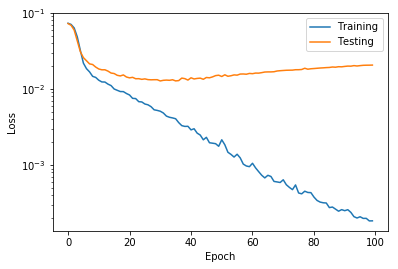

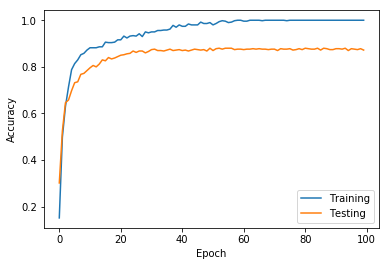

Saving models...
The classification accuracy:  0.872



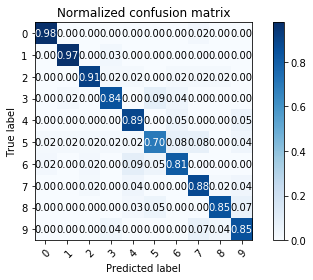

In [14]:
tailored_cnn_mnist = Tailored_CNN_Mnist().to(device)

t_criterion = nn.CrossEntropyLoss()
t_optimizer = optim.Adam(tailored_cnn_mnist.parameters(), lr=0.001)
t_stats = learningStats()

train(tailored_cnn_mnist,'tailor_cnn_Smnist', 
      trainloader_cnn,testloader_cnn, 
      t_criterion, 
      t_optimizer,
      t_stats,
      epoch=EPOCH2)

y_true, y_pred = get_labels(tailored_cnn_mnist, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

## experiment FashionMnist

### for full size Fashion-MNIST

In [15]:
trainset_cnn = FashionMNIST(root='./data', train=True, transform=transforms.Compose([
            transforms.ToTensor()]))

trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset_cnn = FashionMNIST(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor()]))

testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

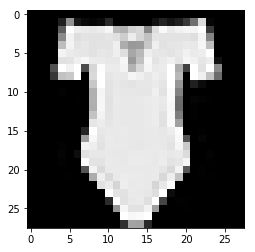

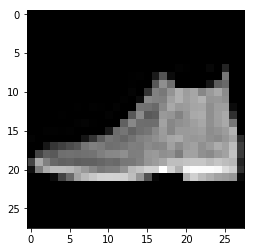

In [16]:
# check if we choose the correct dataset
plt.imshow(next(iter(trainloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

plt.imshow(next(iter(testloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

* train the raw CNN on Fashion-MNIST

  3%|▎         | 1/30 [00:12<05:59, 12.39s/it]


Epoch :          0,   12385.8370 ms elapsed
loss = 0.019647     (min = 0.019647    )  	accuracy = 0.77555    (max = 0.77555   )
loss = 0.016234     (min = 0.016234    )  	accuracy = 0.814      (max = 0.814     )


 10%|█         | 3/30 [00:37<05:38, 12.52s/it]


Epoch :          2,   13007.9800 ms elapsed
loss = 0.0127       (min = 0.0127      )  	accuracy = 0.8556     (max = 0.8556    )
loss = 0.013058     (min = 0.013058    )  	accuracy = 0.8481     (max = 0.8481    )


 17%|█▋        | 5/30 [01:02<05:11, 12.44s/it]


Epoch :          4,   12554.4410 ms elapsed
loss = 0.011282     (min = 0.011282    )  	accuracy = 0.8708     (max = 0.8708    )
loss = 0.012521     (min = 0.012223    )  	accuracy = 0.8563     (max = 0.8604    )


 23%|██▎       | 7/30 [01:27<04:47, 12.49s/it]


Epoch :          6,   12419.3900 ms elapsed
loss = 0.010507     (min = 0.010507    )  	accuracy = 0.87905    (max = 0.87905   )
loss = 0.011455     (min = 0.011455    )  	accuracy = 0.8692     (max = 0.8692    )


 30%|███       | 9/30 [01:52<04:25, 12.63s/it]


Epoch :          8,   12851.6660 ms elapsed
loss = 0.01005      (min = 0.01005     )  	accuracy = 0.88333    (max = 0.88333   )
loss = 0.011081     (min = 0.011081    )  	accuracy = 0.8732     (max = 0.8732    )


 37%|███▋      | 11/30 [02:19<04:05, 12.93s/it]


Epoch :         10,   13556.3350 ms elapsed
loss = 0.0096729    (min = 0.0096729   )  	accuracy = 0.88902    (max = 0.88902   )
loss = 0.010856     (min = 0.010856    )  	accuracy = 0.8774     (max = 0.8774    )


 43%|████▎     | 13/30 [02:45<03:40, 12.96s/it]


Epoch :         12,   13116.5120 ms elapsed
loss = 0.0093963    (min = 0.0093963   )  	accuracy = 0.89105    (max = 0.89105   )
loss = 0.011008     (min = 0.010856    )  	accuracy = 0.8742     (max = 0.8774    )


 50%|█████     | 15/30 [03:10<03:12, 12.83s/it]


Epoch :         14,   12306.7940 ms elapsed
loss = 0.0091802    (min = 0.0091802   )  	accuracy = 0.89397    (max = 0.89397   )
loss = 0.010714     (min = 0.010714    )  	accuracy = 0.8778     (max = 0.8778    )


 57%|█████▋    | 17/30 [03:35<02:42, 12.51s/it]


Epoch :         16,   12111.1420 ms elapsed
loss = 0.0089638    (min = 0.0089638   )  	accuracy = 0.89503    (max = 0.89503   )
loss = 0.010826     (min = 0.010714    )  	accuracy = 0.8754     (max = 0.8795    )


 63%|██████▎   | 19/30 [03:59<02:14, 12.25s/it]


Epoch :         18,   12016.2620 ms elapsed
loss = 0.0088714    (min = 0.0088714   )  	accuracy = 0.8969     (max = 0.8969    )
loss = 0.01065      (min = 0.010573    )  	accuracy = 0.8793     (max = 0.8799    )


 70%|███████   | 21/30 [04:24<01:51, 12.38s/it]


Epoch :         20,   12167.8440 ms elapsed
loss = 0.0087172    (min = 0.0087172   )  	accuracy = 0.8985     (max = 0.8985    )
loss = 0.010612     (min = 0.010573    )  	accuracy = 0.8764     (max = 0.8799    )


 77%|███████▋  | 23/30 [04:48<01:26, 12.36s/it]


Epoch :         22,   12450.6040 ms elapsed
loss = 0.0086141    (min = 0.0086141   )  	accuracy = 0.89975    (max = 0.89975   )
loss = 0.010729     (min = 0.010573    )  	accuracy = 0.8813     (max = 0.882     )


 83%|████████▎ | 25/30 [05:13<01:01, 12.22s/it]


Epoch :         24,   11879.0120 ms elapsed
loss = 0.0084787    (min = 0.0084787   )  	accuracy = 0.90067    (max = 0.90067   )
loss = 0.010438     (min = 0.010345    )  	accuracy = 0.8825     (max = 0.8825    )


 90%|█████████ | 27/30 [05:38<00:37, 12.42s/it]


Epoch :         26,   12548.9060 ms elapsed
loss = 0.0083905    (min = 0.0083905   )  	accuracy = 0.90263    (max = 0.90263   )
loss = 0.010806     (min = 0.010345    )  	accuracy = 0.8822     (max = 0.8825    )


 97%|█████████▋| 29/30 [06:03<00:12, 12.52s/it]


Epoch :         28,   12929.5510 ms elapsed
loss = 0.008298     (min = 0.008298    )  	accuracy = 0.9036     (max = 0.9036    )
loss = 0.010626     (min = 0.010345    )  	accuracy = 0.882      (max = 0.8843    )


100%|██████████| 30/30 [06:16<00:00, 12.61s/it]


Finished Training


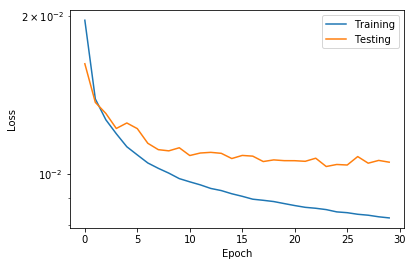

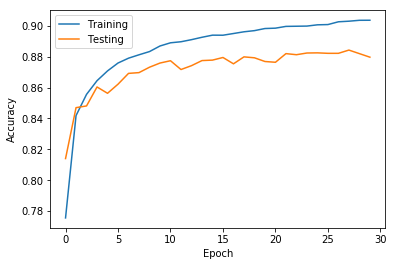

Saving models...
The classification accuracy:  0.8797



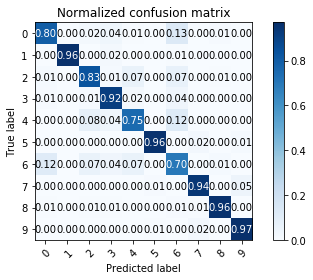

In [17]:
# use the same network structure as for mninst task
raw_cnn_fashion = Raw_CNN_Mnist().to(device)

raw_criterion = nn.CrossEntropyLoss()
raw_optimizer = optim.Adam(raw_cnn_fashion.parameters(), lr=0.001)
raw_stats = learningStats()

train(raw_cnn_fashion,'raw_cnn_fashion',
      trainloader_cnn,testloader_cnn,
      raw_criterion, 
      raw_optimizer,
      raw_stats,
      epoch=EPOCH)

y_true, y_pred = get_labels(raw_cnn_fashion, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* train the tailored CNN on Fashion-MNIST

  3%|▎         | 1/30 [00:12<06:11, 12.80s/it]


Epoch :          0,   12800.6100 ms elapsed
loss = 0.021039     (min = 0.021039    )  	accuracy = 0.7609     (max = 0.7609    )
loss = 0.017261     (min = 0.017261    )  	accuracy = 0.7969     (max = 0.7969    )


 10%|█         | 3/30 [00:37<05:40, 12.60s/it]


Epoch :          2,   12266.2120 ms elapsed
loss = 0.014165     (min = 0.014165    )  	accuracy = 0.83978    (max = 0.83978   )
loss = 0.014728     (min = 0.014728    )  	accuracy = 0.8316     (max = 0.8316    )


 17%|█▋        | 5/30 [01:02<05:11, 12.47s/it]


Epoch :          4,   12165.7370 ms elapsed
loss = 0.012308     (min = 0.012308    )  	accuracy = 0.86342    (max = 0.86342   )
loss = 0.012488     (min = 0.012488    )  	accuracy = 0.8578     (max = 0.8578    )


 23%|██▎       | 7/30 [01:26<04:42, 12.27s/it]


Epoch :          6,   11885.2180 ms elapsed
loss = 0.011227     (min = 0.011227    )  	accuracy = 0.87522    (max = 0.87522   )
loss = 0.011828     (min = 0.011828    )  	accuracy = 0.8729     (max = 0.8729    )


 30%|███       | 9/30 [01:50<04:15, 12.17s/it]


Epoch :          8,   11919.0650 ms elapsed
loss = 0.010624     (min = 0.010624    )  	accuracy = 0.8816     (max = 0.8816    )
loss = 0.011711     (min = 0.011711    )  	accuracy = 0.8699     (max = 0.8729    )


 37%|███▋      | 11/30 [02:15<03:53, 12.28s/it]


Epoch :         10,   12679.2140 ms elapsed
loss = 0.010114     (min = 0.010114    )  	accuracy = 0.88737    (max = 0.88737   )
loss = 0.010912     (min = 0.010912    )  	accuracy = 0.8781     (max = 0.8781    )


 43%|████▎     | 13/30 [02:39<03:26, 12.14s/it]


Epoch :         12,   12048.6470 ms elapsed
loss = 0.0097795    (min = 0.0097795   )  	accuracy = 0.89015    (max = 0.89015   )
loss = 0.010568     (min = 0.010568    )  	accuracy = 0.8843     (max = 0.8843    )


 50%|█████     | 15/30 [03:03<03:00, 12.04s/it]


Epoch :         14,   11902.2700 ms elapsed
loss = 0.0094425    (min = 0.0094425   )  	accuracy = 0.89378    (max = 0.89378   )
loss = 0.010632     (min = 0.010568    )  	accuracy = 0.8795     (max = 0.8843    )


 57%|█████▋    | 17/30 [03:27<02:37, 12.11s/it]


Epoch :         16,   12195.8610 ms elapsed
loss = 0.0092438    (min = 0.0092438   )  	accuracy = 0.89505    (max = 0.89505   )
loss = 0.010165     (min = 0.010165    )  	accuracy = 0.8854     (max = 0.8854    )


 63%|██████▎   | 19/30 [03:53<02:16, 12.38s/it]


Epoch :         18,   12483.3280 ms elapsed
loss = 0.0090525    (min = 0.0090525   )  	accuracy = 0.89808    (max = 0.89808   )
loss = 0.010682     (min = 0.010165    )  	accuracy = 0.8776     (max = 0.8854    )


 70%|███████   | 21/30 [04:18<01:51, 12.43s/it]


Epoch :         20,   12551.8480 ms elapsed
loss = 0.0088919    (min = 0.0088919   )  	accuracy = 0.89962    (max = 0.89962   )
loss = 0.010065     (min = 0.010065    )  	accuracy = 0.8865     (max = 0.8865    )


 77%|███████▋  | 23/30 [04:42<01:25, 12.27s/it]


Epoch :         22,   11898.6500 ms elapsed
loss = 0.0087448    (min = 0.0087448   )  	accuracy = 0.90128    (max = 0.90128   )
loss = 0.010184     (min = 0.010065    )  	accuracy = 0.887      (max = 0.887     )


 83%|████████▎ | 25/30 [05:06<01:01, 12.29s/it]


Epoch :         24,   12333.0980 ms elapsed
loss = 0.0086249    (min = 0.0086249   )  	accuracy = 0.90228    (max = 0.90262   )
loss = 0.010033     (min = 0.010033    )  	accuracy = 0.8941     (max = 0.8941    )


 90%|█████████ | 27/30 [05:31<00:37, 12.33s/it]


Epoch :         26,   12210.1750 ms elapsed
loss = 0.0084882    (min = 0.0084882   )  	accuracy = 0.9028     (max = 0.9028    )
loss = 0.0099606    (min = 0.0099606   )  	accuracy = 0.8866     (max = 0.8941    )


 97%|█████████▋| 29/30 [05:57<00:12, 12.57s/it]


Epoch :         28,   12793.8550 ms elapsed
loss = 0.0083941    (min = 0.0083941   )  	accuracy = 0.90452    (max = 0.90452   )
loss = 0.010186     (min = 0.0096964   )  	accuracy = 0.8867     (max = 0.8941    )


100%|██████████| 30/30 [06:09<00:00, 12.54s/it]


Finished Training


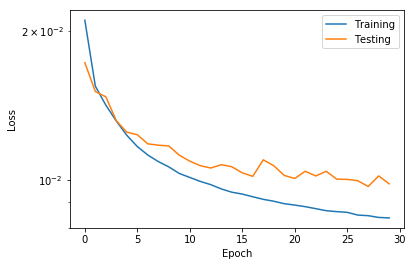

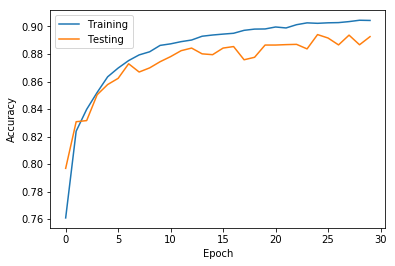

Saving models...
The classification accuracy:  0.8926



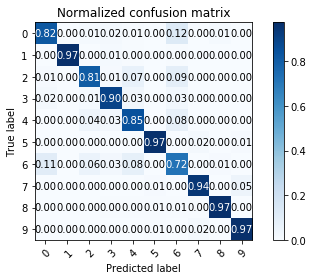

In [18]:
tailored_cnn_fashion = Tailored_CNN_Mnist().to(device)

t_criterion = nn.CrossEntropyLoss()
t_optimizer = optim.Adam(tailored_cnn_fashion.parameters(), lr=0.001)
t_stats = learningStats()

train(tailored_cnn_fashion,'tailor_cnn_fashion', 
      trainloader_cnn,testloader_cnn, 
      t_criterion, 
      t_optimizer,
      t_stats,
      epoch=EPOCH)

y_true, y_pred = get_labels(tailored_cnn_fashion, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

### for small size Fashion-MNIST

In [19]:
trainset_cnn = FashionMNIST500('./data', train=True)

trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset_cnn = FashionMNIST500('./data', train=False)

testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

* train the raw CNN on small Fashion-MNIST


  1%|          | 1/100 [00:00<00:35,  2.76it/s]


Epoch :          0,     361.4990 ms elapsed
loss = 0.07362      (min = 0.07362     )  	accuracy = 0.098      (max = 0.098     )
loss = 0.073118     (min = 0.073118    )  	accuracy = 0.098      (max = 0.098     )


  3%|▎         | 3/100 [00:01<00:35,  2.71it/s]


Epoch :          2,     376.9580 ms elapsed
loss = 0.068164     (min = 0.068164    )  	accuracy = 0.2        (max = 0.226     )
loss = 0.065031     (min = 0.065031    )  	accuracy = 0.278      (max = 0.278     )


  5%|▌         | 5/100 [00:01<00:35,  2.66it/s]


Epoch :          4,     374.3120 ms elapsed
loss = 0.046243     (min = 0.046243    )  	accuracy = 0.636      (max = 0.636     )
loss = 0.038859     (min = 0.038859    )  	accuracy = 0.698      (max = 0.698     )


  7%|▋         | 7/100 [00:02<00:34,  2.68it/s]


Epoch :          6,     366.9590 ms elapsed
loss = 0.027668     (min = 0.027668    )  	accuracy = 0.734      (max = 0.734     )
loss = 0.027032     (min = 0.027032    )  	accuracy = 0.692      (max = 0.698     )


  9%|▉         | 9/100 [00:03<00:34,  2.62it/s]


Epoch :          8,     386.7330 ms elapsed
loss = 0.02347      (min = 0.02347     )  	accuracy = 0.77       (max = 0.77      )
loss = 0.024118     (min = 0.024118    )  	accuracy = 0.722      (max = 0.722     )


 11%|█         | 11/100 [00:04<00:33,  2.69it/s]


Epoch :         10,     351.8730 ms elapsed
loss = 0.020432     (min = 0.020432    )  	accuracy = 0.78       (max = 0.78      )
loss = 0.022417     (min = 0.022417    )  	accuracy = 0.746      (max = 0.746     )


 13%|█▎        | 13/100 [00:04<00:32,  2.67it/s]


Epoch :         12,     368.9660 ms elapsed
loss = 0.018824     (min = 0.018824    )  	accuracy = 0.802      (max = 0.802     )
loss = 0.021279     (min = 0.021279    )  	accuracy = 0.762      (max = 0.762     )


 15%|█▌        | 15/100 [00:05<00:32,  2.65it/s]


Epoch :         14,     368.3680 ms elapsed
loss = 0.017912     (min = 0.017912    )  	accuracy = 0.822      (max = 0.822     )
loss = 0.020952     (min = 0.020859    )  	accuracy = 0.76       (max = 0.762     )


 17%|█▋        | 17/100 [00:06<00:30,  2.70it/s]


Epoch :         16,     354.9350 ms elapsed
loss = 0.016732     (min = 0.016732    )  	accuracy = 0.826      (max = 0.826     )
loss = 0.02095      (min = 0.020151    )  	accuracy = 0.73       (max = 0.774     )


 19%|█▉        | 19/100 [00:07<00:30,  2.63it/s]


Epoch :         18,     374.6010 ms elapsed
loss = 0.015519     (min = 0.015519    )  	accuracy = 0.828      (max = 0.828     )
loss = 0.019573     (min = 0.019573    )  	accuracy = 0.78       (max = 0.786     )


 21%|██        | 21/100 [00:07<00:30,  2.61it/s]


Epoch :         20,     386.0480 ms elapsed
loss = 0.014874     (min = 0.014874    )  	accuracy = 0.842      (max = 0.842     )
loss = 0.019671     (min = 0.019555    )  	accuracy = 0.79       (max = 0.79      )


 23%|██▎       | 23/100 [00:08<00:29,  2.65it/s]


Epoch :         22,     368.2510 ms elapsed
loss = 0.014963     (min = 0.014828    )  	accuracy = 0.828      (max = 0.846     )
loss = 0.019639     (min = 0.019555    )  	accuracy = 0.788      (max = 0.79      )


 25%|██▌       | 25/100 [00:09<00:28,  2.65it/s]


Epoch :         24,     365.5140 ms elapsed
loss = 0.013653     (min = 0.013653    )  	accuracy = 0.856      (max = 0.856     )
loss = 0.019628     (min = 0.019079    )  	accuracy = 0.764      (max = 0.79      )


 27%|██▋       | 27/100 [00:10<00:27,  2.61it/s]


Epoch :         26,     387.4120 ms elapsed
loss = 0.01266      (min = 0.01266     )  	accuracy = 0.86       (max = 0.86      )
loss = 0.018378     (min = 0.018378    )  	accuracy = 0.806      (max = 0.806     )


 29%|██▉       | 29/100 [00:10<00:26,  2.67it/s]


Epoch :         28,     362.2360 ms elapsed
loss = 0.012152     (min = 0.012152    )  	accuracy = 0.876      (max = 0.89      )
loss = 0.018773     (min = 0.018378    )  	accuracy = 0.802      (max = 0.806     )


 31%|███       | 31/100 [00:11<00:26,  2.62it/s]


Epoch :         30,     370.9810 ms elapsed
loss = 0.011265     (min = 0.011265    )  	accuracy = 0.886      (max = 0.89      )
loss = 0.019379     (min = 0.018378    )  	accuracy = 0.768      (max = 0.806     )


 33%|███▎      | 33/100 [00:12<00:25,  2.62it/s]


Epoch :         32,     388.0350 ms elapsed
loss = 0.010656     (min = 0.010656    )  	accuracy = 0.884      (max = 0.89      )
loss = 0.018349     (min = 0.018335    )  	accuracy = 0.802      (max = 0.806     )


 35%|███▌      | 35/100 [00:13<00:24,  2.64it/s]


Epoch :         34,     365.4860 ms elapsed
loss = 0.010566     (min = 0.010566    )  	accuracy = 0.892      (max = 0.894     )
loss = 0.020599     (min = 0.018335    )  	accuracy = 0.774      (max = 0.806     )


 37%|███▋      | 37/100 [00:14<00:24,  2.61it/s]


Epoch :         36,     378.3150 ms elapsed
loss = 0.010323     (min = 0.010323    )  	accuracy = 0.892      (max = 0.894     )
loss = 0.018516     (min = 0.018335    )  	accuracy = 0.796      (max = 0.806     )


 39%|███▉      | 39/100 [00:14<00:23,  2.62it/s]


Epoch :         38,     387.7360 ms elapsed
loss = 0.0098872    (min = 0.0098496   )  	accuracy = 0.888      (max = 0.894     )
loss = 0.019037     (min = 0.018335    )  	accuracy = 0.8        (max = 0.812     )


 41%|████      | 41/100 [00:15<00:22,  2.64it/s]


Epoch :         40,     372.9390 ms elapsed
loss = 0.0085951    (min = 0.0085951   )  	accuracy = 0.922      (max = 0.922     )
loss = 0.018291     (min = 0.018291    )  	accuracy = 0.806      (max = 0.812     )


 43%|████▎     | 43/100 [00:16<00:20,  2.76it/s]


Epoch :         42,     343.1060 ms elapsed
loss = 0.0079917    (min = 0.0079917   )  	accuracy = 0.922      (max = 0.922     )
loss = 0.020131     (min = 0.018233    )  	accuracy = 0.788      (max = 0.812     )


 45%|████▌     | 45/100 [00:16<00:19,  2.76it/s]


Epoch :         44,     372.1510 ms elapsed
loss = 0.0080454    (min = 0.0079917   )  	accuracy = 0.918      (max = 0.922     )
loss = 0.018522     (min = 0.018233    )  	accuracy = 0.812      (max = 0.812     )


 47%|████▋     | 47/100 [00:17<00:19,  2.72it/s]


Epoch :         46,     368.6160 ms elapsed
loss = 0.0078178    (min = 0.0078178   )  	accuracy = 0.924      (max = 0.928     )
loss = 0.018528     (min = 0.018233    )  	accuracy = 0.814      (max = 0.814     )


 49%|████▉     | 49/100 [00:18<00:18,  2.73it/s]


Epoch :         48,     359.7580 ms elapsed
loss = 0.0073329    (min = 0.0073329   )  	accuracy = 0.938      (max = 0.942     )
loss = 0.018771     (min = 0.018233    )  	accuracy = 0.812      (max = 0.814     )


 51%|█████     | 51/100 [00:19<00:18,  2.68it/s]


Epoch :         50,     385.8890 ms elapsed
loss = 0.006615     (min = 0.006615    )  	accuracy = 0.948      (max = 0.948     )
loss = 0.018807     (min = 0.018233    )  	accuracy = 0.814      (max = 0.814     )


 53%|█████▎    | 53/100 [00:19<00:17,  2.67it/s]


Epoch :         52,     363.3280 ms elapsed
loss = 0.0065001    (min = 0.0065001   )  	accuracy = 0.94       (max = 0.948     )
loss = 0.018709     (min = 0.018233    )  	accuracy = 0.798      (max = 0.814     )


 55%|█████▌    | 55/100 [00:20<00:17,  2.61it/s]


Epoch :         54,     376.5080 ms elapsed
loss = 0.0062127    (min = 0.0061819   )  	accuracy = 0.952      (max = 0.952     )
loss = 0.018674     (min = 0.018233    )  	accuracy = 0.808      (max = 0.814     )


 57%|█████▋    | 57/100 [00:21<00:16,  2.62it/s]


Epoch :         56,     380.5790 ms elapsed
loss = 0.0059365    (min = 0.0057684   )  	accuracy = 0.942      (max = 0.952     )
loss = 0.019383     (min = 0.018233    )  	accuracy = 0.814      (max = 0.814     )


 59%|█████▉    | 59/100 [00:22<00:15,  2.64it/s]


Epoch :         58,     370.0640 ms elapsed
loss = 0.0060507    (min = 0.0057441   )  	accuracy = 0.958      (max = 0.958     )
loss = 0.021019     (min = 0.018233    )  	accuracy = 0.79       (max = 0.814     )


 61%|██████    | 61/100 [00:23<00:14,  2.61it/s]


Epoch :         60,     374.6210 ms elapsed
loss = 0.0055559    (min = 0.0055559   )  	accuracy = 0.944      (max = 0.958     )
loss = 0.019344     (min = 0.018233    )  	accuracy = 0.814      (max = 0.814     )


 63%|██████▎   | 63/100 [00:23<00:14,  2.63it/s]


Epoch :         62,     388.0860 ms elapsed
loss = 0.004927     (min = 0.004927    )  	accuracy = 0.962      (max = 0.962     )
loss = 0.019974     (min = 0.018233    )  	accuracy = 0.806      (max = 0.814     )


 65%|██████▌   | 65/100 [00:24<00:13,  2.59it/s]


Epoch :         64,     376.3300 ms elapsed
loss = 0.0050445    (min = 0.004927    )  	accuracy = 0.952      (max = 0.962     )
loss = 0.023494     (min = 0.018233    )  	accuracy = 0.762      (max = 0.814     )


 67%|██████▋   | 67/100 [00:25<00:12,  2.63it/s]


Epoch :         66,     369.2120 ms elapsed
loss = 0.0043268    (min = 0.0043268   )  	accuracy = 0.964      (max = 0.964     )
loss = 0.020138     (min = 0.018233    )  	accuracy = 0.804      (max = 0.814     )


 69%|██████▉   | 69/100 [00:26<00:11,  2.59it/s]


Epoch :         68,     397.5980 ms elapsed
loss = 0.0041746    (min = 0.0041746   )  	accuracy = 0.964      (max = 0.964     )
loss = 0.02032      (min = 0.018233    )  	accuracy = 0.798      (max = 0.814     )


 71%|███████   | 71/100 [00:26<00:11,  2.60it/s]


Epoch :         70,     391.7270 ms elapsed
loss = 0.0039164    (min = 0.0039164   )  	accuracy = 0.966      (max = 0.966     )
loss = 0.020512     (min = 0.018233    )  	accuracy = 0.818      (max = 0.818     )


 73%|███████▎  | 73/100 [00:27<00:10,  2.66it/s]


Epoch :         72,     367.2410 ms elapsed
loss = 0.0036987    (min = 0.0036987   )  	accuracy = 0.968      (max = 0.968     )
loss = 0.020413     (min = 0.018233    )  	accuracy = 0.808      (max = 0.818     )


 75%|███████▌  | 75/100 [00:28<00:09,  2.62it/s]


Epoch :         74,     386.3020 ms elapsed
loss = 0.0035708    (min = 0.0035708   )  	accuracy = 0.974      (max = 0.974     )
loss = 0.021161     (min = 0.018233    )  	accuracy = 0.802      (max = 0.818     )


 77%|███████▋  | 77/100 [00:29<00:08,  2.65it/s]


Epoch :         76,     373.1640 ms elapsed
loss = 0.0036447    (min = 0.0035254   )  	accuracy = 0.966      (max = 0.974     )
loss = 0.020874     (min = 0.018233    )  	accuracy = 0.814      (max = 0.818     )


 79%|███████▉  | 79/100 [00:29<00:07,  2.63it/s]


Epoch :         78,     386.2380 ms elapsed
loss = 0.0035768    (min = 0.0032801   )  	accuracy = 0.964      (max = 0.978     )
loss = 0.021869     (min = 0.018233    )  	accuracy = 0.79       (max = 0.818     )


 81%|████████  | 81/100 [00:30<00:07,  2.59it/s]


Epoch :         80,     381.2740 ms elapsed
loss = 0.0031148    (min = 0.0031148   )  	accuracy = 0.968      (max = 0.98      )
loss = 0.022822     (min = 0.018233    )  	accuracy = 0.788      (max = 0.818     )


 83%|████████▎ | 83/100 [00:31<00:06,  2.56it/s]


Epoch :         82,     405.2420 ms elapsed
loss = 0.0037427    (min = 0.0031148   )  	accuracy = 0.964      (max = 0.98      )
loss = 0.021537     (min = 0.018233    )  	accuracy = 0.804      (max = 0.818     )


 85%|████████▌ | 85/100 [00:32<00:05,  2.59it/s]


Epoch :         84,     372.1470 ms elapsed
loss = 0.0029447    (min = 0.002665    )  	accuracy = 0.976      (max = 0.98      )
loss = 0.021901     (min = 0.018233    )  	accuracy = 0.802      (max = 0.818     )


 87%|████████▋ | 87/100 [00:32<00:04,  2.61it/s]


Epoch :         86,     377.5350 ms elapsed
loss = 0.0025366    (min = 0.0025366   )  	accuracy = 0.982      (max = 0.982     )
loss = 0.022209     (min = 0.018233    )  	accuracy = 0.804      (max = 0.818     )


 89%|████████▉ | 89/100 [00:33<00:04,  2.61it/s]


Epoch :         88,     371.8480 ms elapsed
loss = 0.0024205    (min = 0.0024205   )  	accuracy = 0.986      (max = 0.986     )
loss = 0.023037     (min = 0.018233    )  	accuracy = 0.798      (max = 0.818     )


 91%|█████████ | 91/100 [00:34<00:03,  2.61it/s]


Epoch :         90,     386.3350 ms elapsed
loss = 0.0024215    (min = 0.0024205   )  	accuracy = 0.982      (max = 0.986     )
loss = 0.023088     (min = 0.018233    )  	accuracy = 0.796      (max = 0.818     )


 93%|█████████▎| 93/100 [00:35<00:02,  2.63it/s]


Epoch :         92,     376.8480 ms elapsed
loss = 0.0020158    (min = 0.0020158   )  	accuracy = 0.984      (max = 0.986     )
loss = 0.022721     (min = 0.018233    )  	accuracy = 0.802      (max = 0.818     )


 95%|█████████▌| 95/100 [00:36<00:01,  2.62it/s]


Epoch :         94,     379.2150 ms elapsed
loss = 0.0021641    (min = 0.0020158   )  	accuracy = 0.988      (max = 0.99      )
loss = 0.023046     (min = 0.018233    )  	accuracy = 0.798      (max = 0.818     )


 97%|█████████▋| 97/100 [00:36<00:01,  2.66it/s]


Epoch :         96,     363.3220 ms elapsed
loss = 0.0022134    (min = 0.0020158   )  	accuracy = 0.986      (max = 0.99      )
loss = 0.023193     (min = 0.018233    )  	accuracy = 0.806      (max = 0.818     )


 99%|█████████▉| 99/100 [00:37<00:00,  2.67it/s]


Epoch :         98,     367.5530 ms elapsed
loss = 0.0021441    (min = 0.0020158   )  	accuracy = 0.982      (max = 0.99      )
loss = 0.024342     (min = 0.018233    )  	accuracy = 0.8        (max = 0.818     )


100%|██████████| 100/100 [00:37<00:00,  2.63it/s]


Finished Training


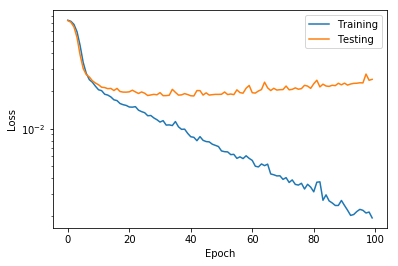

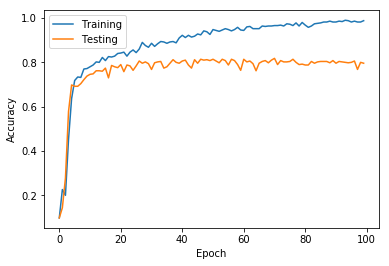

Saving models...
The classification accuracy:  0.796



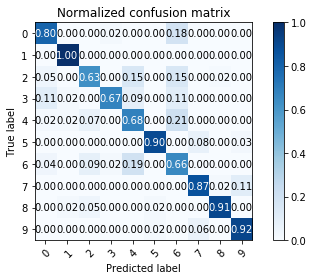

In [20]:
# use the same network structure as for mninst task
raw_cnn_fashion = Raw_CNN_Mnist().to(device)

raw_criterion = nn.CrossEntropyLoss()
raw_optimizer = optim.Adam(raw_cnn_fashion.parameters(), lr=0.001)
raw_stats = learningStats()

train(raw_cnn_fashion,'raw_cnn_Sfashion',
      trainloader_cnn,testloader_cnn,
      raw_criterion, 
      raw_optimizer,
      raw_stats,
      epoch=EPOCH2)

y_true, y_pred = get_labels(raw_cnn_fashion, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* train the tailored CNN on small Fashion-MNIST

  1%|          | 1/100 [00:00<00:38,  2.57it/s]


Epoch :          0,     388.9200 ms elapsed
loss = 0.073251     (min = 0.073251    )  	accuracy = 0.114      (max = 0.114     )
loss = 0.072152     (min = 0.072152    )  	accuracy = 0.174      (max = 0.174     )


  3%|▎         | 3/100 [00:01<00:36,  2.64it/s]


Epoch :          2,     372.2710 ms elapsed
loss = 0.059266     (min = 0.059266    )  	accuracy = 0.494      (max = 0.494     )
loss = 0.049993     (min = 0.049993    )  	accuracy = 0.616      (max = 0.616     )


  5%|▌         | 5/100 [00:01<00:35,  2.71it/s]


Epoch :          4,     363.2440 ms elapsed
loss = 0.033561     (min = 0.033561    )  	accuracy = 0.62       (max = 0.62      )
loss = 0.030854     (min = 0.030854    )  	accuracy = 0.648      (max = 0.648     )


  7%|▋         | 7/100 [00:02<00:33,  2.81it/s]


Epoch :          6,     338.1000 ms elapsed
loss = 0.028533     (min = 0.028533    )  	accuracy = 0.668      (max = 0.668     )
loss = 0.027466     (min = 0.027466    )  	accuracy = 0.67       (max = 0.67      )


  9%|▉         | 9/100 [00:03<00:32,  2.76it/s]


Epoch :          8,     360.4380 ms elapsed
loss = 0.025102     (min = 0.025102    )  	accuracy = 0.71       (max = 0.716     )
loss = 0.025644     (min = 0.025644    )  	accuracy = 0.702      (max = 0.702     )


 11%|█         | 11/100 [00:03<00:32,  2.78it/s]


Epoch :         10,     365.6410 ms elapsed
loss = 0.023998     (min = 0.023998    )  	accuracy = 0.732      (max = 0.74      )
loss = 0.025508     (min = 0.024951    )  	accuracy = 0.698      (max = 0.704     )


 13%|█▎        | 13/100 [00:04<00:30,  2.81it/s]


Epoch :         12,     352.7830 ms elapsed
loss = 0.021976     (min = 0.021976    )  	accuracy = 0.76       (max = 0.76      )
loss = 0.02438      (min = 0.024295    )  	accuracy = 0.682      (max = 0.718     )


 15%|█▌        | 15/100 [00:05<00:30,  2.81it/s]


Epoch :         14,     357.1420 ms elapsed
loss = 0.021581     (min = 0.021296    )  	accuracy = 0.766      (max = 0.778     )
loss = 0.024802     (min = 0.02381     )  	accuracy = 0.682      (max = 0.718     )


 17%|█▋        | 17/100 [00:06<00:28,  2.88it/s]


Epoch :         16,     335.5080 ms elapsed
loss = 0.020317     (min = 0.020317    )  	accuracy = 0.778      (max = 0.778     )
loss = 0.022323     (min = 0.022323    )  	accuracy = 0.722      (max = 0.722     )


 19%|█▉        | 19/100 [00:06<00:28,  2.83it/s]


Epoch :         18,     339.3150 ms elapsed
loss = 0.019446     (min = 0.019446    )  	accuracy = 0.784      (max = 0.794     )
loss = 0.02254      (min = 0.022323    )  	accuracy = 0.726      (max = 0.736     )


 21%|██        | 21/100 [00:07<00:27,  2.90it/s]


Epoch :         20,     339.8390 ms elapsed
loss = 0.018579     (min = 0.018579    )  	accuracy = 0.802      (max = 0.802     )
loss = 0.022396     (min = 0.022323    )  	accuracy = 0.732      (max = 0.736     )


 23%|██▎       | 23/100 [00:08<00:27,  2.78it/s]


Epoch :         22,     377.0670 ms elapsed
loss = 0.017558     (min = 0.017498    )  	accuracy = 0.822      (max = 0.822     )
loss = 0.021988     (min = 0.021645    )  	accuracy = 0.714      (max = 0.736     )


 25%|██▌       | 25/100 [00:08<00:27,  2.78it/s]


Epoch :         24,     356.2630 ms elapsed
loss = 0.018531     (min = 0.017498    )  	accuracy = 0.81       (max = 0.822     )
loss = 0.021943     (min = 0.021645    )  	accuracy = 0.73       (max = 0.736     )


 27%|██▋       | 27/100 [00:09<00:26,  2.81it/s]


Epoch :         26,     347.0430 ms elapsed
loss = 0.016644     (min = 0.016644    )  	accuracy = 0.818      (max = 0.824     )
loss = 0.021286     (min = 0.021241    )  	accuracy = 0.736      (max = 0.742     )


 29%|██▉       | 29/100 [00:10<00:25,  2.84it/s]


Epoch :         28,     339.9110 ms elapsed
loss = 0.015607     (min = 0.015607    )  	accuracy = 0.83       (max = 0.84      )
loss = 0.020847     (min = 0.020847    )  	accuracy = 0.742      (max = 0.742     )


 31%|███       | 31/100 [00:11<00:24,  2.80it/s]


Epoch :         30,     368.4060 ms elapsed
loss = 0.016245     (min = 0.015437    )  	accuracy = 0.808      (max = 0.842     )
loss = 0.022636     (min = 0.020847    )  	accuracy = 0.71       (max = 0.742     )


 33%|███▎      | 33/100 [00:11<00:24,  2.77it/s]


Epoch :         32,     370.0360 ms elapsed
loss = 0.01478      (min = 0.01478     )  	accuracy = 0.846      (max = 0.846     )
loss = 0.021399     (min = 0.020847    )  	accuracy = 0.724      (max = 0.742     )


 35%|███▌      | 35/100 [00:12<00:23,  2.76it/s]


Epoch :         34,     354.6840 ms elapsed
loss = 0.015922     (min = 0.01478     )  	accuracy = 0.826      (max = 0.846     )
loss = 0.022216     (min = 0.020847    )  	accuracy = 0.732      (max = 0.752     )


 37%|███▋      | 37/100 [00:13<00:22,  2.82it/s]


Epoch :         36,     351.2900 ms elapsed
loss = 0.014488     (min = 0.014488    )  	accuracy = 0.844      (max = 0.846     )
loss = 0.020604     (min = 0.020604    )  	accuracy = 0.746      (max = 0.752     )


 39%|███▉      | 39/100 [00:13<00:21,  2.82it/s]


Epoch :         38,     363.1150 ms elapsed
loss = 0.014265     (min = 0.014111    )  	accuracy = 0.844      (max = 0.848     )
loss = 0.022327     (min = 0.020604    )  	accuracy = 0.73       (max = 0.752     )


 41%|████      | 41/100 [00:14<00:21,  2.78it/s]


Epoch :         40,     371.2230 ms elapsed
loss = 0.01374      (min = 0.01374     )  	accuracy = 0.848      (max = 0.862     )
loss = 0.020867     (min = 0.020604    )  	accuracy = 0.748      (max = 0.752     )


 43%|████▎     | 43/100 [00:15<00:20,  2.78it/s]


Epoch :         42,     358.7750 ms elapsed
loss = 0.013234     (min = 0.013234    )  	accuracy = 0.85       (max = 0.862     )
loss = 0.022464     (min = 0.020604    )  	accuracy = 0.736      (max = 0.752     )


 45%|████▌     | 45/100 [00:16<00:19,  2.82it/s]


Epoch :         44,     343.2060 ms elapsed
loss = 0.013914     (min = 0.013234    )  	accuracy = 0.856      (max = 0.862     )
loss = 0.021649     (min = 0.020604    )  	accuracy = 0.748      (max = 0.754     )


 47%|████▋     | 47/100 [00:16<00:18,  2.82it/s]


Epoch :         46,     346.8940 ms elapsed
loss = 0.013171     (min = 0.013171    )  	accuracy = 0.848      (max = 0.862     )
loss = 0.020681     (min = 0.020604    )  	accuracy = 0.752      (max = 0.758     )


 49%|████▉     | 49/100 [00:17<00:18,  2.79it/s]


Epoch :         48,     362.0520 ms elapsed
loss = 0.012298     (min = 0.012298    )  	accuracy = 0.88       (max = 0.88      )
loss = 0.021303     (min = 0.020604    )  	accuracy = 0.75       (max = 0.758     )


 51%|█████     | 51/100 [00:18<00:17,  2.75it/s]


Epoch :         50,     368.2930 ms elapsed
loss = 0.013079     (min = 0.012298    )  	accuracy = 0.86       (max = 0.88      )
loss = 0.022737     (min = 0.020604    )  	accuracy = 0.748      (max = 0.758     )


 53%|█████▎    | 53/100 [00:18<00:17,  2.69it/s]


Epoch :         52,     380.2660 ms elapsed
loss = 0.012089     (min = 0.012089    )  	accuracy = 0.868      (max = 0.882     )
loss = 0.022293     (min = 0.020604    )  	accuracy = 0.746      (max = 0.758     )


 55%|█████▌    | 55/100 [00:19<00:16,  2.67it/s]


Epoch :         54,     382.5290 ms elapsed
loss = 0.011858     (min = 0.011858    )  	accuracy = 0.87       (max = 0.882     )
loss = 0.0211       (min = 0.020604    )  	accuracy = 0.762      (max = 0.762     )


 57%|█████▋    | 57/100 [00:20<00:15,  2.71it/s]


Epoch :         56,     353.3180 ms elapsed
loss = 0.012297     (min = 0.011858    )  	accuracy = 0.866      (max = 0.882     )
loss = 0.021002     (min = 0.020604    )  	accuracy = 0.762      (max = 0.762     )


 59%|█████▉    | 59/100 [00:21<00:14,  2.76it/s]


Epoch :         58,     346.5140 ms elapsed
loss = 0.011761     (min = 0.01134     )  	accuracy = 0.876      (max = 0.882     )
loss = 0.021011     (min = 0.020604    )  	accuracy = 0.768      (max = 0.772     )


 61%|██████    | 61/100 [00:21<00:14,  2.75it/s]


Epoch :         60,     363.8800 ms elapsed
loss = 0.011212     (min = 0.010745    )  	accuracy = 0.878      (max = 0.888     )
loss = 0.023306     (min = 0.020604    )  	accuracy = 0.748      (max = 0.772     )


 63%|██████▎   | 63/100 [00:22<00:13,  2.77it/s]


Epoch :         62,     358.8620 ms elapsed
loss = 0.010801     (min = 0.010745    )  	accuracy = 0.896      (max = 0.896     )
loss = 0.02176      (min = 0.020604    )  	accuracy = 0.76       (max = 0.772     )


 65%|██████▌   | 65/100 [00:23<00:12,  2.82it/s]


Epoch :         64,     341.9360 ms elapsed
loss = 0.010893     (min = 0.010745    )  	accuracy = 0.886      (max = 0.896     )
loss = 0.021914     (min = 0.020604    )  	accuracy = 0.764      (max = 0.776     )


 67%|██████▋   | 67/100 [00:24<00:11,  2.79it/s]


Epoch :         66,     358.7750 ms elapsed
loss = 0.01072      (min = 0.01072     )  	accuracy = 0.882      (max = 0.896     )
loss = 0.022182     (min = 0.020604    )  	accuracy = 0.766      (max = 0.776     )


 69%|██████▉   | 69/100 [00:24<00:11,  2.76it/s]


Epoch :         68,     367.1660 ms elapsed
loss = 0.010443     (min = 0.010443    )  	accuracy = 0.9        (max = 0.9       )
loss = 0.023436     (min = 0.020604    )  	accuracy = 0.752      (max = 0.776     )


 71%|███████   | 71/100 [00:25<00:10,  2.80it/s]


Epoch :         70,     344.8610 ms elapsed
loss = 0.01001      (min = 0.01001     )  	accuracy = 0.892      (max = 0.9       )
loss = 0.021714     (min = 0.020604    )  	accuracy = 0.768      (max = 0.776     )


 73%|███████▎  | 73/100 [00:26<00:09,  2.83it/s]


Epoch :         72,     340.3860 ms elapsed
loss = 0.0099806    (min = 0.0099806   )  	accuracy = 0.906      (max = 0.906     )
loss = 0.022378     (min = 0.020604    )  	accuracy = 0.762      (max = 0.776     )


 75%|███████▌  | 75/100 [00:26<00:09,  2.76it/s]


Epoch :         74,     362.0650 ms elapsed
loss = 0.009341     (min = 0.009341    )  	accuracy = 0.902      (max = 0.906     )
loss = 0.021779     (min = 0.020604    )  	accuracy = 0.778      (max = 0.782     )


 77%|███████▋  | 77/100 [00:27<00:08,  2.79it/s]


Epoch :         76,     358.0180 ms elapsed
loss = 0.0097092    (min = 0.0091923   )  	accuracy = 0.892      (max = 0.906     )
loss = 0.02222      (min = 0.020604    )  	accuracy = 0.78       (max = 0.782     )


 79%|███████▉  | 79/100 [00:28<00:07,  2.85it/s]


Epoch :         78,     331.7210 ms elapsed
loss = 0.0095122    (min = 0.0091923   )  	accuracy = 0.908      (max = 0.908     )
loss = 0.022706     (min = 0.020604    )  	accuracy = 0.764      (max = 0.782     )


 81%|████████  | 81/100 [00:29<00:06,  2.86it/s]


Epoch :         80,     335.3210 ms elapsed
loss = 0.009261     (min = 0.0091398   )  	accuracy = 0.896      (max = 0.908     )
loss = 0.023605     (min = 0.020604    )  	accuracy = 0.766      (max = 0.784     )


 83%|████████▎ | 83/100 [00:29<00:06,  2.82it/s]


Epoch :         82,     364.7190 ms elapsed
loss = 0.0087913    (min = 0.0087913   )  	accuracy = 0.914      (max = 0.914     )
loss = 0.02214      (min = 0.020604    )  	accuracy = 0.776      (max = 0.784     )


 85%|████████▌ | 85/100 [00:30<00:05,  2.86it/s]


Epoch :         84,     340.7440 ms elapsed
loss = 0.0084941    (min = 0.0084941   )  	accuracy = 0.926      (max = 0.926     )
loss = 0.022146     (min = 0.020604    )  	accuracy = 0.78       (max = 0.788     )


 87%|████████▋ | 87/100 [00:31<00:04,  2.82it/s]


Epoch :         86,     354.1120 ms elapsed
loss = 0.0080223    (min = 0.0080223   )  	accuracy = 0.922      (max = 0.926     )
loss = 0.022804     (min = 0.020604    )  	accuracy = 0.774      (max = 0.788     )


 89%|████████▉ | 89/100 [00:31<00:03,  2.79it/s]


Epoch :         88,     348.8750 ms elapsed
loss = 0.0098319    (min = 0.0080223   )  	accuracy = 0.898      (max = 0.926     )
loss = 0.023299     (min = 0.020604    )  	accuracy = 0.77       (max = 0.788     )


 91%|█████████ | 91/100 [00:32<00:03,  2.83it/s]


Epoch :         90,     341.7350 ms elapsed
loss = 0.0080086    (min = 0.0080086   )  	accuracy = 0.914      (max = 0.926     )
loss = 0.024784     (min = 0.020604    )  	accuracy = 0.764      (max = 0.788     )


 93%|█████████▎| 93/100 [00:33<00:02,  2.78it/s]


Epoch :         92,     374.0380 ms elapsed
loss = 0.0078879    (min = 0.0078879   )  	accuracy = 0.926      (max = 0.926     )
loss = 0.022396     (min = 0.020604    )  	accuracy = 0.786      (max = 0.788     )


 95%|█████████▌| 95/100 [00:34<00:01,  2.83it/s]


Epoch :         94,     339.7710 ms elapsed
loss = 0.0076027    (min = 0.0076027   )  	accuracy = 0.922      (max = 0.926     )
loss = 0.023191     (min = 0.020604    )  	accuracy = 0.784      (max = 0.788     )


 97%|█████████▋| 97/100 [00:34<00:01,  2.75it/s]


Epoch :         96,     370.5690 ms elapsed
loss = 0.0086106    (min = 0.0076027   )  	accuracy = 0.912      (max = 0.926     )
loss = 0.024288     (min = 0.020604    )  	accuracy = 0.754      (max = 0.788     )


 99%|█████████▉| 99/100 [00:35<00:00,  2.79it/s]


Epoch :         98,     349.3100 ms elapsed
loss = 0.0086103    (min = 0.0076027   )  	accuracy = 0.9        (max = 0.926     )
loss = 0.023843     (min = 0.020604    )  	accuracy = 0.764      (max = 0.788     )


100%|██████████| 100/100 [00:35<00:00,  2.77it/s]


Finished Training


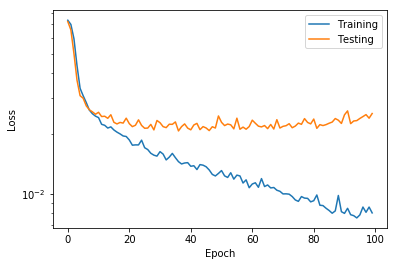

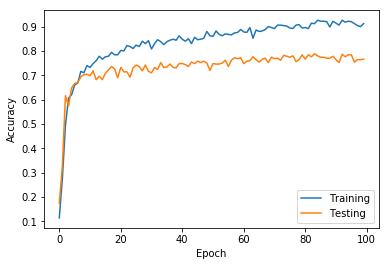

Saving models...
The classification accuracy:  0.766



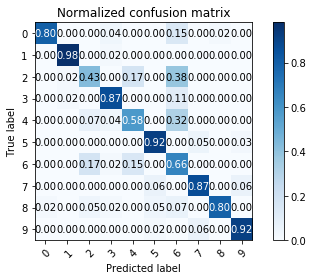

In [21]:
tailored_cnn_fashion = Tailored_CNN_Mnist().to(device)

t_criterion = nn.CrossEntropyLoss()
t_optimizer = optim.Adam(tailored_cnn_fashion.parameters(), lr=0.001)
t_stats = learningStats()

train(tailored_cnn_fashion,'tailor_cnn_Sfashion', 
      trainloader_cnn,testloader_cnn, 
      t_criterion, 
      t_optimizer,
      t_stats,
      epoch=EPOCH2)

y_true, y_pred = get_labels(tailored_cnn_fashion, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

# Test for SNN with weights from tailored CNN

## Notes on the conv
* kernel size of time should be 1, otherwise it gets convolved as well.
* bias=False
* replace their pool layer with nn.AvgPool3d. The pool they used is a $sum*\theta$ not an average.
* should recieve the Spikes from the previous layer
* the input value should be within [0,1] before they go into the DataLoader

## Pipeline
raw data(B,C,H,W) --- spike generation ---> spike(B,C,H,W,T) --- Conv3d on spikes ---> X(t) for every t of T --- eq 1: LIF, threshold and reset ---> intermediate V(t), the membrane potential --- based on V(t) ---> Spikes for the next layer.

In [22]:
class custmized_SNN_Mnist(nn.Module):
    
    def __init__(self, thetas, leaks=[0,0,0,0,0], V_mins=[0,0,0,0,0]):
        super(custmized_SNN_Mnist, self).__init__()
        self.conv1 = convLayer(1, 3, 5, theta=thetas[0], padding=1)
        self.pool1 = poolLayer(2, theta=thetas[1])
        self.conv2 = convLayer(3, 12, 5, theta=thetas[2],padding=1)        
        self.pool2 = poolLayer(2, theta=thetas[3])
        self.fc1   = denseLayer((5 * 5 * 12), 10, theta=thetas[4])
        
    def forward(self, spikeInput):
        spike_conv1 = self.conv1(spikeInput)
        #print(spike_conv1)
        spike_pool1 = self.pool1(spike_conv1)
        #print(spike_pool1)
        spike_conv2 = self.conv2(spike_pool1)
        #print(spike_conv2.shape)
        spike_pool2 = self.pool2(spike_conv2)
        spike_for_fc1 = spike_pool2.reshape(-1, 5 * 5 * 12, 1, 1, spike_pool2.shape[-1])
        spikeOut = self.fc1(spike_for_fc1)
        
        return spikeOut

## experiment Spike MNIST
### for full size Spike MNIST

In [23]:
TIME_BINS = 25

In [24]:
# Dataset and dataLoader instances.
testingSet_M = SpikeDataset(datasetPath = './data', dataset='mnist',TimeBins=TIME_BINS,
                    small=False, train=False)

testLoader_M = DataLoader(dataset=testingSet_M, batch_size=64, shuffle=False, num_workers=4)

* check the performance of a randomly initialized SNN

In [25]:
thetas = [1, 0.99, 1, 0.99, 1]

custmized_snn_mnist = custmized_SNN_Mnist(thetas=thetas).to(device)

The classification accuracy:  0.1009



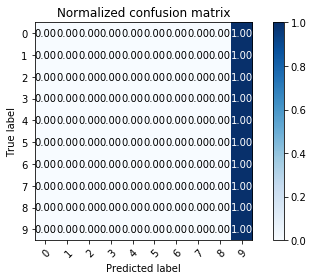

In [26]:
y_true, y_pred = get_labels(custmized_snn_mnist, testLoader_M, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* now try with the weights learned from tailor_cnn

In [27]:
# script to transfer the weights
tailor_cnn_weights = load_dict("tailor_cnn_mnist")
snn_weights = custmized_snn_mnist.state_dict()

for k in iter(tailor_cnn_weights):
    print("Layer {}".format(k))
    print(tailor_cnn_weights[k].shape)
    if k.startswith('conv') or k.startswith('fc'):
        snn_weights[k] = tailor_cnn_weights[k].reshape(snn_weights[k].shape)

Layer conv1.weight
torch.Size([3, 1, 5, 5])
Layer conv2.weight
torch.Size([12, 3, 5, 5])
Layer fc1.weight
torch.Size([10, 300])


In [28]:
transformed_snn_mnist = custmized_SNN_Mnist(thetas=thetas).to(device)
transformed_snn_mnist.load_state_dict(snn_weights)

# this warning can be ignored, it happens when using jupyter 
# even the weights are passed without problem

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

The classification accuracy:  0.7042



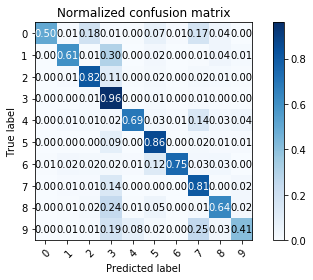

In [29]:
y_true, y_pred = get_labels(transformed_snn_mnist, testLoader_M, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

### for small size Spike MNIST

In [30]:
# Dataset and dataLoader instances.
testingSet_M = SpikeDataset(datasetPath = './data', dataset='mnist',TimeBins=TIME_BINS,
                    small=True, train=False)

testLoader_M = DataLoader(dataset=testingSet_M, batch_size=64, shuffle=False, num_workers=4)

The classification accuracy:  0.678



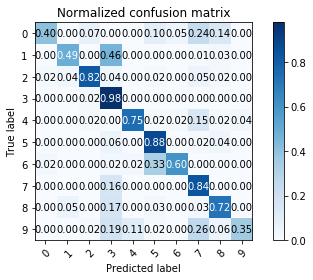

In [31]:
y_true, y_pred = get_labels(transformed_snn_mnist, testLoader_M, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

## experiment Fashion-MNIST
### for full size Spike Fashion-MNIST

In [32]:
testingSet_F = SpikeDataset(datasetPath = './data', dataset='fashion',TimeBins=TIME_BINS,
                    small=False, train=False)
testLoader_F = DataLoader(dataset=testingSet_F, batch_size=64, shuffle=False, num_workers=4)

In [33]:
thetas = [10, 0.7, 0.9, 0.7, 1]

custmized_snn_fashion = custmized_SNN_Mnist(thetas=thetas).to(device)

* check the performance of a randomly initialized SNN

The classification accuracy:  0.1



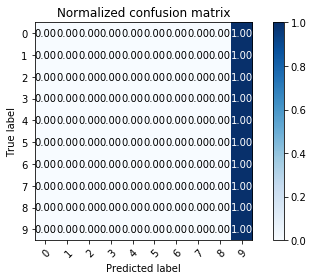

In [34]:
y_true, y_pred = get_labels(custmized_snn_fashion, testLoader_F, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* check the performance of a randomly initialized SNN with learnt weights

Layer conv1.weight
torch.Size([3, 1, 5, 5])
Layer conv2.weight
torch.Size([12, 3, 5, 5])
Layer fc1.weight
torch.Size([10, 300])
The classification accuracy:  0.3274



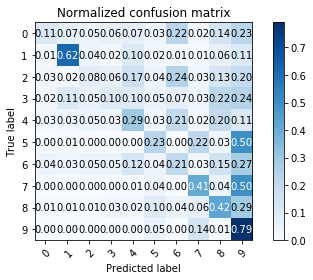

In [35]:
# script to transfer the weights
tailor_cnn_weights = load_dict("tailor_cnn_fashion")
snn_weights = custmized_snn_fashion.state_dict()

for k in iter(tailor_cnn_weights):
    print("Layer {}".format(k))
    print(tailor_cnn_weights[k].shape)
    if k.startswith('conv') or k.startswith('fc'):
        snn_weights[k] = tailor_cnn_weights[k].reshape(snn_weights[k].shape)
        
transformed_snn_fashion = custmized_SNN_Mnist(thetas=thetas).to(device)
transformed_snn_fashion.load_state_dict(snn_weights)

# this warning can be ignored, it happens when using jupyter 
# even the weights are passed without problem

y_true, y_pred = get_labels(transformed_snn_fashion, testLoader_F, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

### for small size Spike Fashion-MNIST

In [36]:
testingSet_F = SpikeDataset(datasetPath = './data', dataset='fashion',TimeBins=TIME_BINS,
                    small=True, train=False)
testLoader_F = DataLoader(dataset=testingSet_F, batch_size=64, shuffle=False, num_workers=4)

* now try with the weights learned from tailor_cnn

The classification accuracy:  0.29



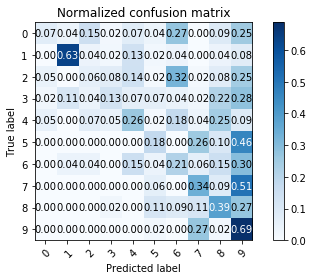

In [37]:
y_true, y_pred = get_labels(transformed_snn_fashion, testLoader_F, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())